Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File read successfully!


dest_port  src_port  bytes_out   entropy  total_entropy        time_start  \
0     9200.0   33936.0        981  5.266184      5166.1265  1613535235833257   
1       53.0   48165.0        192  3.224730       619.1482    16094970493478   
2    32870.0    9200.0          0  0.000000         0.0000  1612151386151534   
3    32880.0    9200.0        436  7.181581      3131.1694  1612155192397563   
4     9200.0   39408.0      36656  1.039850     38560.7540  1611102882245731   

           time_end   duration   label  
0  1613535235833257   0.000000  benign  
1  1609497074363861  25.016062  benign  
2  1612151386151534   0.000000  benign  
3  1612155192397563   0.000000  benign  
4  1611102882263957   0.018226  benign

In [ ]:
df.size

53104896

In [ ]:
import pandas as pd

try:
  file_path = '/content/drive/MyDrive/Data-science-project/combined_dataset.csv' # Replace with your file path
  chunksize = 10000  # Define the size of each batch (e.g., 10,000 rows)

  # Read the CSV file in batches
  for i, chunk in enumerate(pd.read_csv(file_path, chunksize=chunksize)):
    print(f"Processing batch {i+1}")
    # Process each chunk (e.g., display the head of the first batch)
    if i == 0:
      display(chunk.head())
    break
    # You can add your processing logic for each chunk here
    # For example: chunk.to_sql('your_table', engine, if_exists='append')

  print("Finished processing all batches.")

except FileNotFoundError:
  print(f"Error: The file was not found at {file_path}")
except Exception as e:
  print(f"An error occurred: {e}")

Processing batch 1


avg_ipt  bytes_in  bytes_out  dest_ip  dest_port   entropy  \
0  2001.600000       663       4606      786     9200.0  5.122674   
1  4289.571429         0        224    15169       53.0  3.326140   
2   769.384615      1001      41956      786     9092.0  0.945283   
3  3000.600000       969      26001      786     9200.0  1.510103   
4  1578.947368      1001      36789      786     9200.0  1.146984   

   num_pkts_out  num_pkts_in  proto  src_ip  src_port          time_end  \
0             5            4      6     786   46484.0  1609671458572914   
1             7            0     17     786   39311.0  1609671471015415   
2            37           24      6     786   57148.0  1609671478569299   
3            10            7      6     786   56324.0  1609671478569699   
4            19            9      6     786   56330.0  1609671478569602   

         time_start  total_entropy   label   duration  
0  1609671448563808    26991.37000  benign  10.009106  
1  1609671440986371      745.05536  benign  30.029043  
2  1609671448553539    40606.54300  benign  30.015760  
3  1609671448558806    40727.48000  benign  30.010893  
4   160967144856498    43344.52000  benign  30.004622

Finished processing all batches.


In [ ]:
!pip install lingam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.0/80.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 11.5 MB/s eta 0:00:00
  Created wheel for semopy: filename=semopy-2.3.11-py3-none-any.whl size=1659682 sha256=c79f54341c796d1b8d6e3524f026464981ec4c898128a40a0187d97086ace607
  Stored in directory: /root/.cache/pip/wheels/d2/9a/31/fae291ff6a649bad125037eef8c7cc63d8c542e14bdcccea37
Successfully built semopy


# Step 1: Preprocessing the Dataset **just run once**

1.1 Feature Selection
Remove non-informative or identifiers: src_ip, dest_ip are anonymized IDs, not numerical measures of traffic behavior.

Keep numeric variables: avg_ipt, bytes_in, bytes_out, entropy, num_pkts_in, num_pkts_out, total_entropy, duration.

Consider encoding proto (protocol) as a number (it’s already numeric).

Drop time_start and time_end for initial analysis (they are timestamps, not features).

1.2 Label Encoding (Optional for Multi-group)
Create a new column label_encoded where:

benign = 0, malicious = 1, outlier = 2.

1.3 Standardization
Scale features (e.g., with StandardScaler) to avoid bias due to magnitude differences (bytes_in vs entropy).



In [ ]:
# --- Step 0: Imports & paths ---------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from joblib import dump
import os

# Input / output
file_path = '/content/drive/MyDrive/Data-science-project/combined_dataset.csv'
out_path  = '/content/drive/MyDrive/Data-science-project/journal-article/combined_dataset_preprocessed.csv'
scaler_path = '/content/drive/MyDrive/Data-science-project/journal-article/standard_scaler.joblib'

chunksize = 100000  # tune for your RAM


In [ ]:
# Columns we want to DROP (ids, timestamps, textual)
drop_cols = {
    'src_ip', 'dest_ip', 'time_start', 'time_end', 'label'  # 'label' kept separately
}

# Candidate numeric feature columns to KEEP (we'll intersect with what's actually present)
candidate_feature_cols = [
    'avg_ipt', 'mean_ipt',                # some releases use mean_ipt, others avg_ipt
    'bytes_in', 'bytes_out',
    'num_pkts_in', 'num_pkts_out',
    'entropy', 'total_entropy',
    'src_port', 'dest_port',
    'proto', 'protocol',                  # some releases use protocol, others proto
    'duration'
]

label_col = 'label'
label_map = {'benign': 0, 'malicious': 1, 'outlier': 2}

In [ ]:
# --- Small helper to decide which columns exist in each chunk -----------------
def pick_columns(df):
    # Features
    feature_cols = [c for c in candidate_feature_cols if c in df.columns]
    # Prefer 'avg_ipt' over 'mean_ipt' if both exist (rare, but just in case)
    if 'avg_ipt' in feature_cols and 'mean_ipt' in feature_cols:
        feature_cols.remove('mean_ipt')
    # Protocol name alignment
    if 'protocol' in feature_cols and 'proto' in feature_cols:
        feature_cols.remove('protocol')  # keep 'proto'
    return feature_cols

# --- First pass: fit scaler incrementally -------------------------------------
scaler = StandardScaler(with_mean=True, with_std=True)

total_rows = 0
print("Pass 1/2: Fitting StandardScaler incrementally...")
try:
    for i, chunk in enumerate(pd.read_csv(file_path, chunksize=chunksize)):
        if i == 0:
            print(f"Columns in file: {list(chunk.columns)}")

        # Identify which columns to use (once, with first chunk)
        feature_cols = pick_columns(chunk)
        if label_col not in chunk.columns:
            raise ValueError(f"'{label_col}' column not found in the dataset.")

        # Keep only features + label (for later encoding in pass 2)
        use_cols = feature_cols + [label_col]

        # Reduce to needed cols
        chunk = chunk[use_cols].copy()

        # Encode label (keep as separate column, not part of scaler)
        chunk['label_encoded'] = chunk[label_col].map(label_map).astype('Int64')

        # NaNs: For scaling, we need no NaNs. Fill with column median (per chunk) safely.
        # We'll do the same strategy in the second pass.
        X = chunk[feature_cols].astype(np.float32)
        X = X.fillna(X.median(numeric_only=True))

        scaler.partial_fit(X)
        total_rows += len(chunk)
        if (i + 1) % 10 == 0:
            print(f"  Processed {total_rows:,} rows so far...")
    print(f"Finished pass 1. Total rows seen: {total_rows:,}")

except FileNotFoundError:
    raise FileNotFoundError(f"Error: The file was not found at {file_path}")
except Exception as e:
    raise RuntimeError(f"An error occurred during pass 1: {e}")

# Save scaler for future use
dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

Pass 1/2: Fitting StandardScaler incrementally...
Columns in file: ['avg_ipt', 'bytes_in', 'bytes_out', 'dest_ip', 'dest_port', 'entropy', 'num_pkts_out', 'num_pkts_in', 'proto', 'src_ip', 'src_port', 'time_end', 'time_start', 'total_entropy', 'label', 'duration']
  Processed 1,000,000 rows so far...
  Processed 2,000,000 rows so far...
  Processed 3,000,000 rows so far...
  Processed 4,000,000 rows so far...
  Processed 5,000,000 rows so far...
  Processed 6,000,000 rows so far...
  Processed 7,000,000 rows so far...
  Processed 8,000,000 rows so far...
  Processed 9,000,000 rows so far...
  Processed 10,000,000 rows so far...
  Processed 11,000,000 rows so far...
  Processed 12,000,000 rows so far...
  Processed 13,000,000 rows so far...
  Processed 14,000,000 rows so far...
  Processed 15,000,000 rows so far...
  Processed 16,000,000 rows so far...
  Processed 17,000,000 rows so far...
  Processed 18,000,000 rows so far...
  Processed 19,000,000 rows so far...
  Processed 20,000,000

In [ ]:
print("Pass 2/2: Transforming and writing preprocessed dataset...")

# Make sure we don't append to an existing file by accident
if os.path.exists(out_path):
    os.remove(out_path)

header_written = False
total_rows_written = 0

try:
    for i, chunk in enumerate(pd.read_csv(file_path, chunksize=chunksize)):
        # Identify which columns to use (same logic)
        feature_cols = pick_columns(chunk)
        use_cols = feature_cols + [label_col]

        chunk = chunk[use_cols].copy()

        # Encode labels
        chunk['label_encoded'] = chunk[label_col].map(label_map).astype('Int64')

        # Scale numeric features
        X = chunk[feature_cols].astype(np.float32)
        X = X.fillna(X.median(numeric_only=True))  # same fill strategy as pass 1

        X_scaled = scaler.transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=feature_cols, index=chunk.index)

        # Put back together
        out_chunk = pd.concat([X_scaled, chunk[['label_encoded']]], axis=1)

        # Write to CSV incrementally
        out_chunk.to_csv(out_path, mode='a', index=False, header=not header_written)
        header_written = True

        total_rows_written += len(out_chunk)
        if i == 0:
            print("Preview of the first transformed batch:")
            display(out_chunk.head())

        if (i + 1) % 10 == 0:
            print(f"  Written {total_rows_written:,} rows so far...")

    print(f"Done! Wrote {total_rows_written:,} preprocessed rows to:\n  {out_path}")

except Exception as e:
    raise RuntimeError(f"An error occurred during pass 2: {e}")

Pass 2/2: Transforming and writing preprocessed dataset...
Preview of the first transformed batch:


avg_ipt  bytes_in  bytes_out  num_pkts_in  num_pkts_out   entropy  \
0 -0.034021  0.066604   0.188284     0.070633     -0.050288  0.906497   
1 -0.033972 -0.198464  -0.487429    -0.261112      0.066575  0.131936   
2 -0.034047  0.201737   5.947725     1.729356      1.819531 -0.894550   
3 -0.033999  0.188944   3.487434     0.319441      0.241871 -0.651033   
4 -0.034030  0.201737   5.150964     0.485313      0.767758 -0.807589   

   total_entropy  src_port  dest_port     proto  duration  label_encoded  
0       0.287295  0.396229  -0.272192 -0.047130  1.719798              0  
1      -0.225039  0.027790  -0.797197  8.363294  5.439072              0  
2       0.553067  0.943982  -0.278391 -0.047130  5.436604              0  
3       0.555427  0.901657  -0.272192 -0.047130  5.435700              0  
4       0.606513  0.901965  -0.272192 -0.047130  5.434535              0

  Written 1,000,000 rows so far...
  Written 2,000,000 rows so far...
  Written 3,000,000 rows so far...
  Written 4,000,000 rows so far...
  Written 5,000,000 rows so far...
  Written 6,000,000 rows so far...
  Written 7,000,000 rows so far...
  Written 8,000,000 rows so far...
  Written 9,000,000 rows so far...
  Written 10,000,000 rows so far...
  Written 11,000,000 rows so far...
  Written 12,000,000 rows so far...
  Written 13,000,000 rows so far...
  Written 14,000,000 rows so far...
  Written 15,000,000 rows so far...
  Written 16,000,000 rows so far...
  Written 17,000,000 rows so far...
  Written 18,000,000 rows so far...
  Written 19,000,000 rows so far...
  Written 20,000,000 rows so far...
  Written 21,000,000 rows so far...
  Written 22,000,000 rows so far...
  Written 23,000,000 rows so far...
  Written 24,000,000 rows so far...
  Written 25,000,000 rows so far...
  Written 26,000,000 rows so far...
  Written 27,000,000 rows so far...
  Written 28,000,000 rows so far...
 

# Steo 2: Apply LiNGAM using samples 600 000

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# === Step 2: Apply LiNGAM approaches (DirectLiNGAM, ICALiNGAM, Multi-group) ===
# Colab-ready

!pip -q install lingam joblib

import pandas as pd
import numpy as np
from pathlib import Path
from joblib import load
from lingam import DirectLiNGAM, ICALiNGAM, MultiGroupDirectLiNGAM

# -------------------- Config --------------------
preprocessed_path = '/content/drive/MyDrive/Data-science-project/journal-article/combined_dataset_preprocessed.csv'
scaler_path       = '/content/drive/MyDrive/Data-science-project/journal-article/standard_scaler.joblib'  # not strictly needed here
out_dir           = Path('/content/drive/MyDrive/Data-science-project/journal-article/lingam_results')
out_dir.mkdir(parents=True, exist_ok=True)

random_state = 42
# For very large datasets, you may want to subsample for speed:
max_rows_for_global = 200_000
max_rows_per_group  = 200_000
edge_threshold = 0.0  # keep all edges; raise to prune small coefficients

# -------------------- Load data --------------------
df = pd.read_csv(preprocessed_path)

# Expect the file created in Step 1 to contain only features + 'label_encoded'
if 'label_encoded' not in df.columns:
    raise ValueError("'label_encoded' not found in the preprocessed dataset.")

feature_cols = [c for c in df.columns if c != 'label_encoded']
label_col = 'label_encoded'

# Optional: load scaler if you need it later
try:
    scaler = load(scaler_path)
except Exception as e:
    print(f"Warning: couldn't load scaler at {scaler_path}: {e}")
    scaler = None

# -------------------- (Helper) Subsample --------------------
def subsample(df_in, n, seed):
    if len(df_in) <= n:
        return df_in
    return df_in.sample(n=n, random_state=seed)

# Global sample (all labels together)
df_global = subsample(df, max_rows_for_global, random_state)

# Group-wise samples
df_benign    = subsample(df[df[label_col] == 0], max_rows_per_group, random_state)
df_malicious = subsample(df[df[label_col] == 1], max_rows_per_group, random_state)
df_outlier   = subsample(df[df[label_col] == 2], max_rows_per_group, random_state)

print("Rows (after subsampling):",
      f"\n  Global:     {len(df_global)}",
      f"\n  Benign:     {len(df_benign)}",
      f"\n  Malicious:  {len(df_malicious)}",
      f"\n  Outlier:    {len(df_outlier)}")

# -------------------- (Helper) Export functions --------------------
def adjacency_to_edgelist(B: np.ndarray, cols, thresh=0.0):
    """Convert adjacency matrix to edge list (i -> j) with weights."""
    edges = []
    for i in range(B.shape[0]):
        for j in range(B.shape[1]):
            w = B[i, j]
            if abs(w) > thresh:
                edges.append((cols[i], cols[j], float(w)))
    return pd.DataFrame(edges, columns=['source', 'target', 'weight'])

def save_results(prefix, model_name, adj, order=None, cols=None):
    # adjacency
    adj_df = pd.DataFrame(adj, index=cols, columns=cols)
    adj_path = out_dir / f'{prefix}_{model_name}_adjacency.csv'
    adj_df.to_csv(adj_path, index=True)
    print(f"Saved adjacency to: {adj_path}")

    # edge list
    edges_df = adjacency_to_edgelist(adj, cols, edge_threshold)
    edges_path = out_dir / f'{prefix}_{model_name}_edges.csv'
    edges_df.to_csv(edges_path, index=False)
    print(f"Saved edge list to: {edges_path} (kept {len(edges_df)} edges)")

    # ordering
    if order is not None:
        order_df = pd.DataFrame({'variable': [cols[i] for i in order], 'position': range(len(order))})
        order_path = out_dir / f'{prefix}_{model_name}_order.csv'
        order_df.to_csv(order_path, index=False)
        print(f"Saved causal order to: {order_path}")

# -------------------- 2.1 DirectLiNGAM (global) --------------------
X_global = df_global[feature_cols].to_numpy()

print("\n=== DirectLiNGAM (global) ===")
direct_model = DirectLiNGAM(random_state=random_state)
direct_model.fit(X_global)

B_direct = direct_model.adjacency_matrix_
order_direct = direct_model.causal_order_

save_results(prefix='global', model_name='direct_lingam',
             adj=B_direct, order=order_direct, cols=feature_cols)

# -------------------- 2.2 ICA-LiNGAM (global) --------------------
print("\n=== ICA-LiNGAM (global) ===")
ica_model = ICALiNGAM(random_state=random_state)
ica_model.fit(X_global)

B_ica = ica_model.adjacency_matrix_
order_ica = ica_model.causal_order_

save_results(prefix='global', model_name='ica_lingam',
             adj=B_ica, order=order_ica, cols=feature_cols)

# -------------------- 2.3 Multi-group LiNGAM --------------------
# We'll compare benign vs malicious only (ignore outliers), if both exist.
groups = []
group_names = []
if len(df_benign) > 0:
    groups.append(df_benign[feature_cols].to_numpy())
    group_names.append('benign')
if len(df_malicious) > 0:
    groups.append(df_malicious[feature_cols].to_numpy())
    group_names.append('malicious')

if len(groups) >= 2:
    print("\n=== MultiGroupDirectLiNGAM (benign vs malicious) ===")
    mg_model = MultiGroupDirectLiNGAM(random_state=random_state)
    mg_model.fit(groups)

    B_mg = mg_model.adjacency_matrix_
    order_mg = mg_model.causal_order_

    save_results(prefix='multi_group_benign_malicious', model_name='mg_direct_lingam',
                 adj=B_mg, order=order_mg, cols=feature_cols)
else:
    print("\n[WARN] Not enough groups (need >= 2) to run MultiGroup LiNGAM. Skipping.")

# -------------------- (Optional) Per-group DirectLiNGAM for comparison --------
def run_per_group(prefix, df_group):
    if len(df_group) == 0:
        print(f"[WARN] No rows in {prefix}; skipping.")
        return
    X = df_group[feature_cols].to_numpy()
    model = DirectLiNGAM(random_state=random_state)
    model.fit(X)
    B = model.adjacency_matrix_
    order = model.causal_order_
    save_results(prefix=prefix, model_name='direct_lingam', adj=B, order=order, cols=feature_cols)

print("\n=== DirectLiNGAM per-label (for comparison) ===")
run_per_group('benign_only', df_benign)
run_per_group('malicious_only', df_malicious)
run_per_group('outlier_only', df_outlier)

print("\nAll done. Outputs saved to:", out_dir)


Rows (after subsampling): 
  Global:     200000 
  Benign:     200000 
  Malicious:  200000 
  Outlier:    200000

=== DirectLiNGAM (global) ===
Saved adjacency to: /content/drive/MyDrive/Data-science-project/journal-article/lingam_results/global_direct_lingam_adjacency.csv
Saved edge list to: /content/drive/MyDrive/Data-science-project/journal-article/lingam_results/global_direct_lingam_edges.csv (kept 47 edges)
Saved causal order to: /content/drive/MyDrive/Data-science-project/journal-article/lingam_results/global_direct_lingam_order.csv

=== ICA-LiNGAM (global) ===
Saved adjacency to: /content/drive/MyDrive/Data-science-project/journal-article/lingam_results/global_ica_lingam_adjacency.csv
Saved edge list to: /content/drive/MyDrive/Data-science-project/journal-article/lingam_results/global_ica_lingam_edges.csv (kept 46 edges)
Saved causal order to: /content/drive/MyDrive/Data-science-project/journal-article/lingam_results/global_ica_lingam_order.csv

=== MultiGroupDirectLiNGAM (beni

# step 3: validation and graph

## trials to grpah

DirectLiNGAM adjacency matrix:


avg_ipt  bytes_in  bytes_out  num_pkts_in  num_pkts_out  \
avg_ipt       0.000000       0.0   0.000000     0.000000      0.000000   
bytes_in      0.000000       0.0  -0.039775     0.548071      0.098714   
bytes_out     0.000000       0.0   0.000000     0.000000      0.559540   
num_pkts_in   0.000000       0.0  -0.072175     0.000000      0.710490   
num_pkts_out  0.008405       0.0   0.000000     0.000000      0.000000   

               entropy  total_entropy  src_port  dest_port     proto  duration  
avg_ipt       0.000000       0.000000  0.000000   0.000000  0.000000   0.00000  
bytes_in     -0.023482       0.305671 -0.016923   0.140199  0.009269   0.04347  
bytes_out     0.000000       0.000000  0.127179   0.000000 -0.007252   0.00000  
num_pkts_in   0.063310       0.204211 -0.022664  -0.044063 -0.010347   0.00000  
num_pkts_out  0.000000       0.000000  0.000000   0.000000 -0.011217   0.00000

ICA-LiNGAM adjacency matrix:


avg_ipt  bytes_in  bytes_out  num_pkts_in  num_pkts_out  \
avg_ipt       0.000000  0.000000        0.0     0.000000      0.000000   
bytes_in      0.000000  0.000000        0.0     0.664595      0.126613   
bytes_out     0.000000 -0.068734        0.0    -0.153186      0.488960   
num_pkts_in   0.005587  0.000000        0.0     0.000000      0.764987   
num_pkts_out  0.008424  0.000000        0.0     0.000000      0.000000   

               entropy  total_entropy  src_port  dest_port  proto  duration  
avg_ipt       0.000000       0.000000  0.000000   0.000000    0.0  0.000000  
bytes_in      0.000000       0.000000  0.000000   0.000000    0.0  0.000000  
bytes_out    -0.144955       0.309685  0.116604  -0.027746    0.0  0.202021  
num_pkts_in   0.000000       0.000000  0.000000   0.000000    0.0  0.000000  
num_pkts_out  0.000000       0.000000  0.000000   0.000000    0.0  0.000000

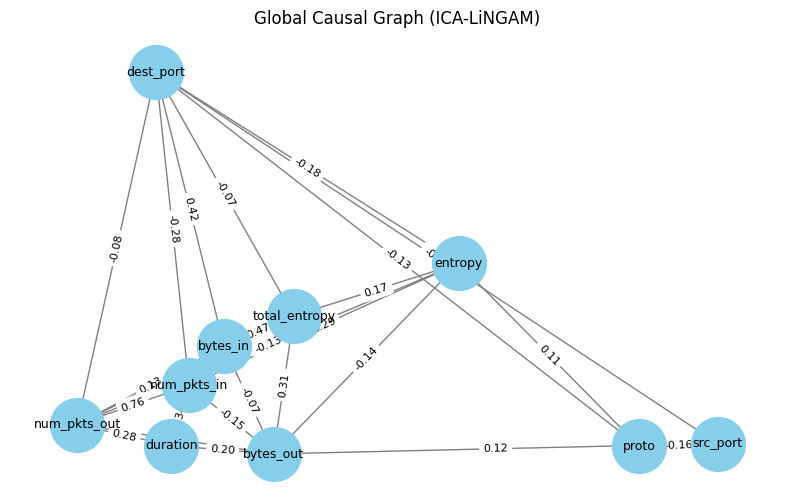

Saved difference matrix (Direct - ICA) to: /content/drive/MyDrive/Data-science-project/journal-article/lingam_results/direct_vs_ica_diff.csv


avg_ipt  bytes_in  bytes_out  num_pkts_in  num_pkts_out  \
avg_ipt       0.000000  0.000000   0.000000     0.000000      0.000000   
bytes_in      0.000000  0.000000  -0.039775    -0.116524     -0.027899   
bytes_out     0.000000  0.068734   0.000000     0.153186      0.070581   
num_pkts_in  -0.005587  0.000000  -0.072175     0.000000     -0.054497   
num_pkts_out -0.000019  0.000000   0.000000     0.000000      0.000000   

               entropy  total_entropy  src_port  dest_port     proto  duration  
avg_ipt       0.000000       0.000000  0.000000   0.000000  0.000000  0.000000  
bytes_in     -0.023482       0.305671 -0.016923   0.140199  0.009269  0.043470  
bytes_out     0.144955      -0.309685  0.010576   0.027746 -0.007252 -0.202021  
num_pkts_in   0.063310       0.204211 -0.022664  -0.044063 -0.010347  0.000000  
num_pkts_out  0.000000       0.000000  0.000000   0.000000 -0.011217  0.000000

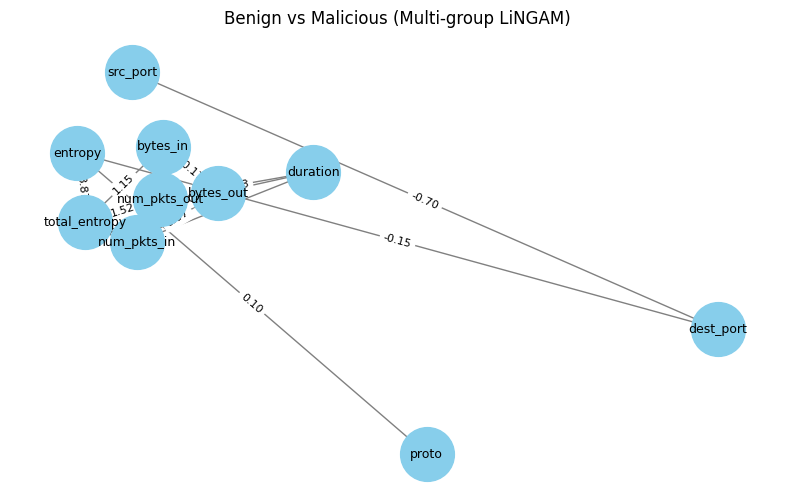

In [ ]:
# === Step 3: Visualization & Validation ===
!pip -q install networkx matplotlib

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path

results_path = Path("/content/drive/MyDrive/Data-science-project/journal-article/lingam_results")
edge_threshold = 0.05  # show only strong edges for visualization

# -------------------- Helper: Load adjacency --------------------
def load_adjacency(name):
    path = results_path / name
    return pd.read_csv(path, index_col=0)

# -------------------- Helper: Plot graph --------------------
def plot_causal_graph(adj_df, title, threshold=0.05):
    G = nx.DiGraph()
    cols = adj_df.columns
    for i in range(len(cols)):
        for j in range(len(cols)):
            w = adj_df.iloc[i, j]
            if abs(w) > threshold:
                G.add_edge(cols[i], cols[j], weight=w)

    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1500)
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True)
    labels = {n: n for n in G.nodes}
    nx.draw_networkx_labels(G, pos, labels, font_size=9)
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title(title)
    plt.axis('off')
    plt.show()

# -------------------- Load Direct & ICA --------------------
adj_direct = load_adjacency("global_direct_lingam_adjacency.csv")
adj_ica    = load_adjacency("global_ica_lingam_adjacency.csv")

print("DirectLiNGAM adjacency matrix:")
display(adj_direct.head())
print("ICA-LiNGAM adjacency matrix:")
display(adj_ica.head())

# -------------------- Plot causal graphs --------------------
plot_causal_graph(adj_direct, "Global Causal Graph (DirectLiNGAM)", threshold=edge_threshold)
plot_causal_graph(adj_ica, "Global Causal Graph (ICA-LiNGAM)", threshold=edge_threshold)

# -------------------- Compare Direct vs ICA --------------------
diff_matrix = adj_direct - adj_ica
diff_path = results_path / "direct_vs_ica_diff.csv"
diff_matrix.to_csv(diff_path)
print(f"Saved difference matrix (Direct - ICA) to: {diff_path}")
display(diff_matrix.head())

# -------------------- Multi-group Comparison --------------------
multi_group_file = results_path / "multi_group_benign_malicious_mg_direct_lingam_adjacency.csv"
if multi_group_file.exists():
    adj_mg = load_adjacency(multi_group_file)
    plot_causal_graph(adj_mg, "Benign vs Malicious (Multi-group LiNGAM)", threshold=edge_threshold)
else:
    print("No multi-group results found.")


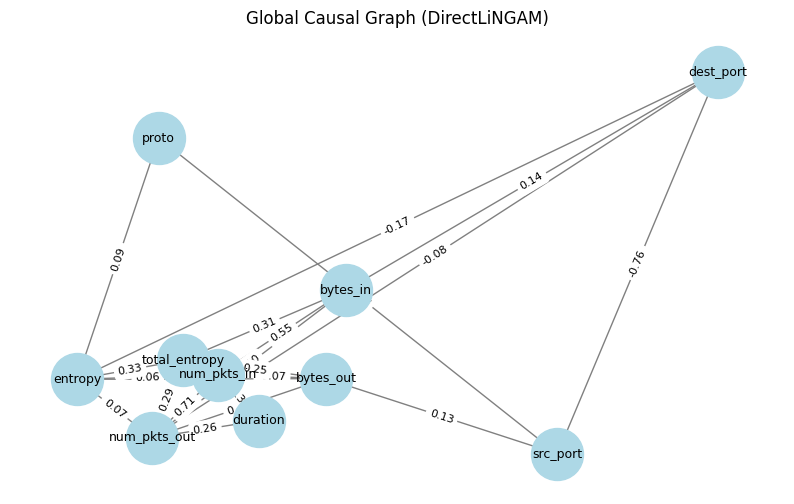

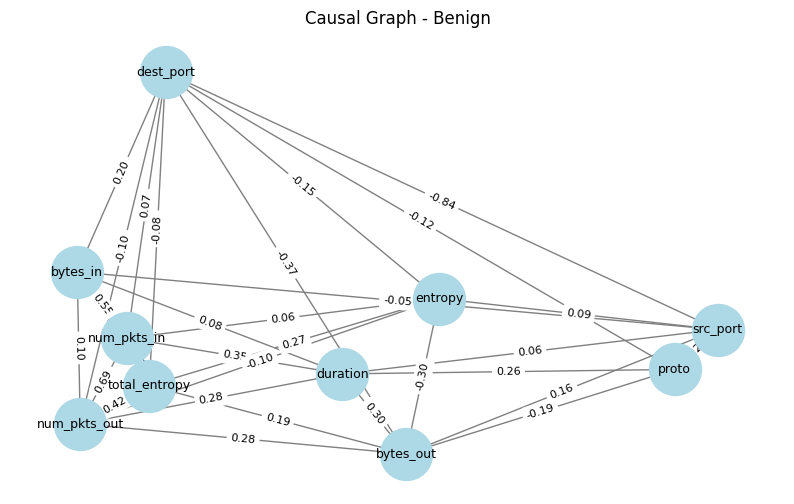

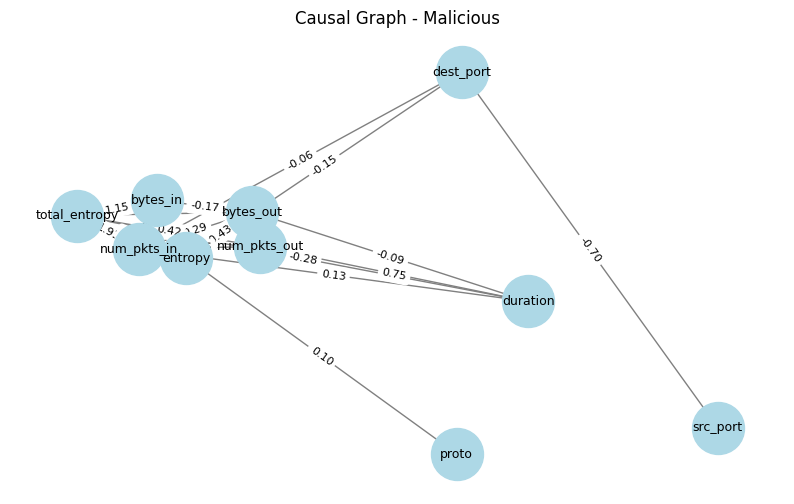

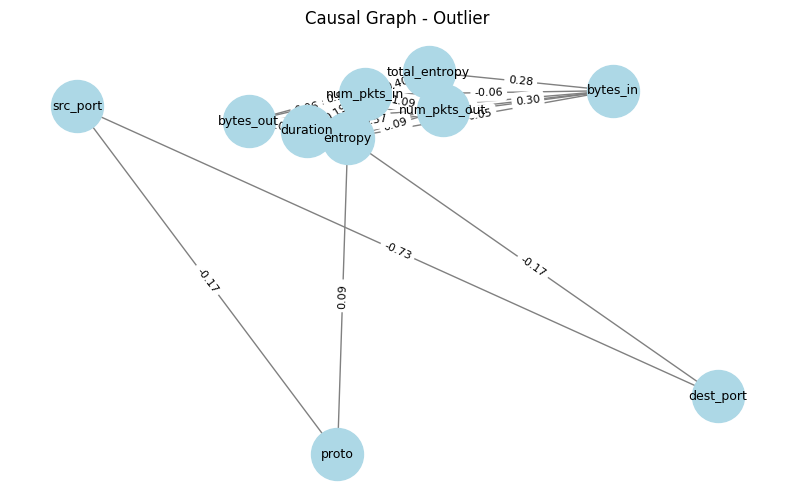

In [ ]:
# === Step 3 (Updated): Plot graphs per class ===
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path

results_path = Path("/content/drive/MyDrive/Data-science-project/journal-article/lingam_results")
edge_threshold = 0.05

def load_adjacency(name):
    path = results_path / name
    if not path.exists():
        print(f"Missing {name}")
        return None
    return pd.read_csv(path, index_col=0)

def plot_causal_graph(adj_df, title, threshold=0.05):
    G = nx.DiGraph()
    cols = adj_df.columns
    for i in range(len(cols)):
        for j in range(len(cols)):
            w = adj_df.iloc[i, j]
            if abs(w) > threshold:
                G.add_edge(cols[i], cols[j], weight=w)

    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1400)
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True)
    nx.draw_networkx_labels(G, pos, font_size=9)
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title(title)
    plt.axis('off')
    plt.show()

# --- Plot Global ---
adj_direct = load_adjacency("global_direct_lingam_adjacency.csv")
if adj_direct is not None:
    plot_causal_graph(adj_direct, "Global Causal Graph (DirectLiNGAM)", threshold=edge_threshold)

# --- Per-Class Graphs ---
for cls in ["benign_only_direct_lingam_adjacency.csv",
            "malicious_only_direct_lingam_adjacency.csv",
            "outlier_only_direct_lingam_adjacency.csv"]:
    adj_cls = load_adjacency(cls)
    if adj_cls is not None:
        class_name = cls.replace("_only_direct_lingam_adjacency.csv", "")
        plot_causal_graph(adj_cls, f"Causal Graph - {class_name.title()}", threshold=edge_threshold)


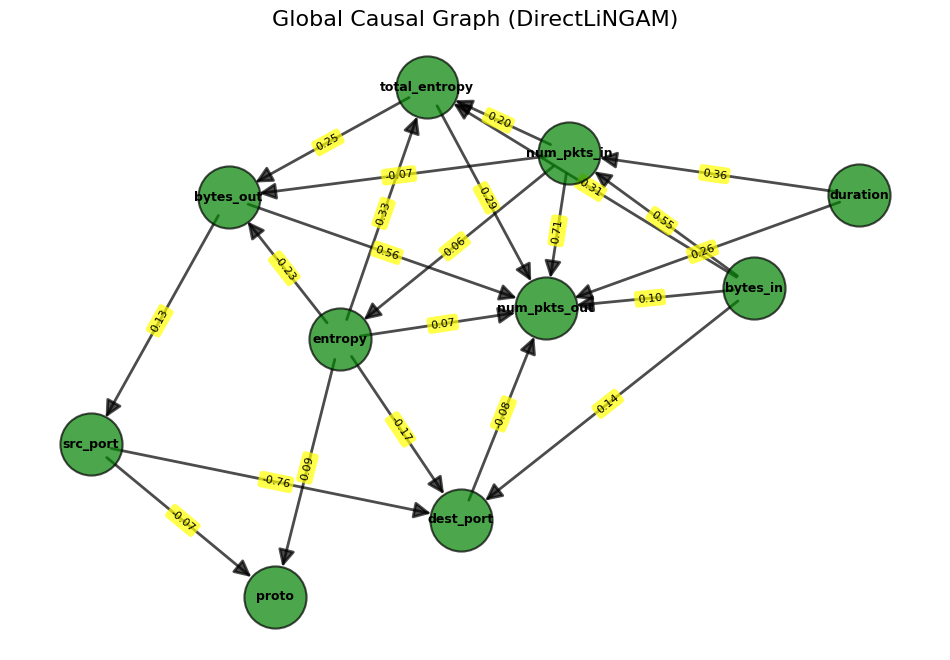

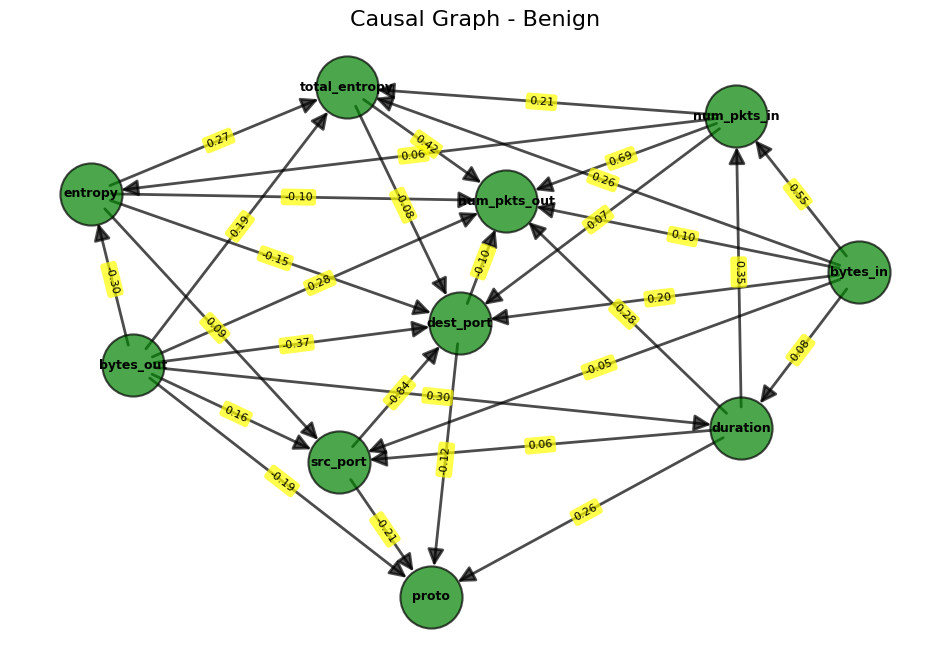

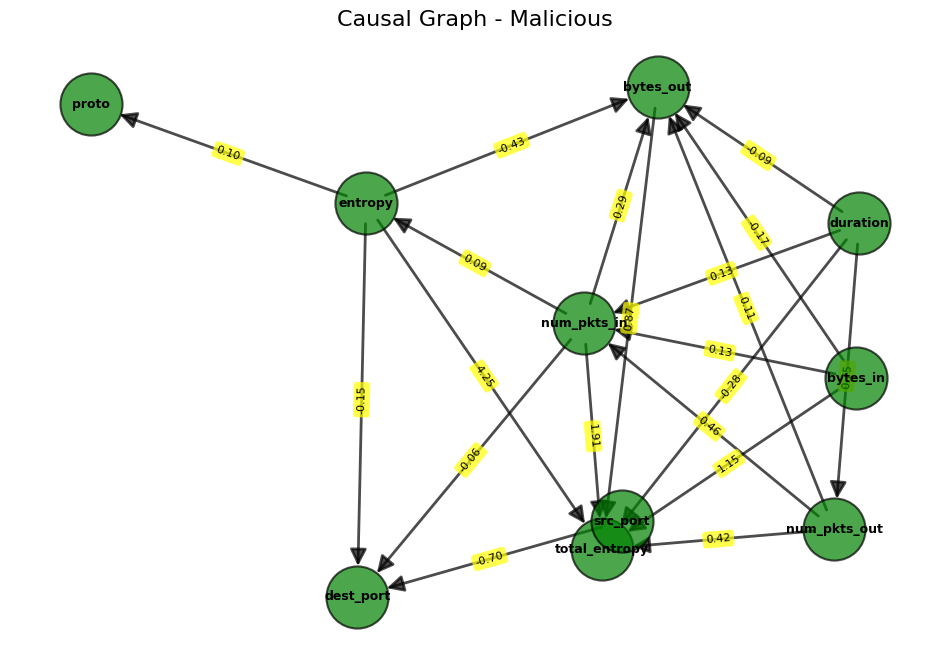

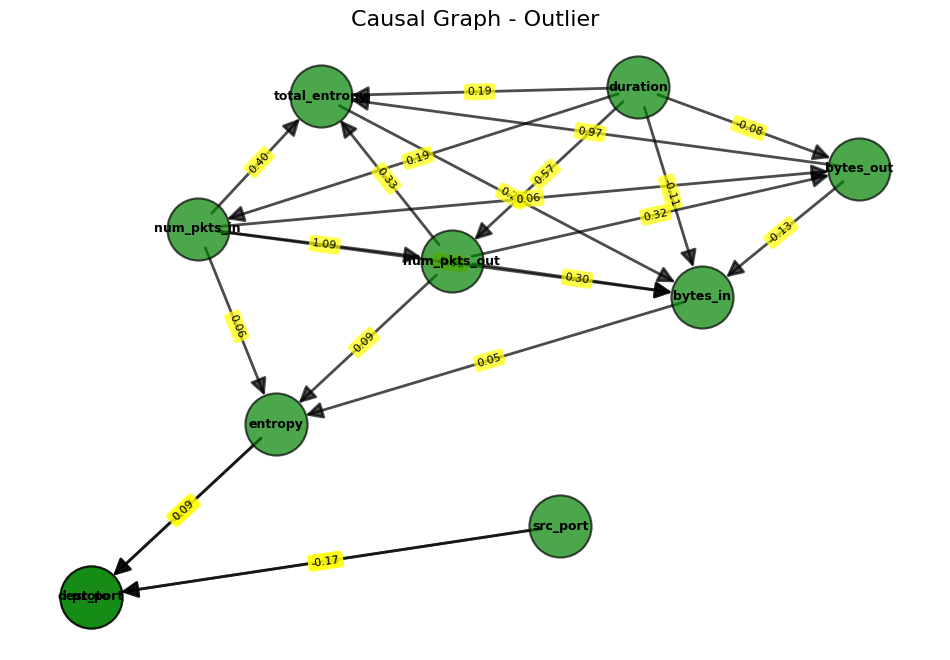

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path

results_path = Path("/content/drive/MyDrive/Data-science-project/journal-article/lingam_results")
edge_threshold = 0.05

def load_adjacency(name):
    path = results_path / name
    if not path.exists():
        print(f"Missing {name}")
        return None
    return pd.read_csv(path, index_col=0)

def plot_causal_graph(adj_df, title, threshold=0.05):
    G = nx.DiGraph()
    cols = adj_df.columns
    for i in range(len(cols)):
        for j in range(len(cols)):
            w = adj_df.iloc[i, j]
            if abs(w) > threshold:
                G.add_edge(cols[i], cols[j], weight=w)

    plt.figure(figsize=(12, 8)) # Increase figure size for better spacing

    # --- Node Positioning and Layout ---
    # Using 'kamada_kawai_layout' often provides better distribution than 'spring_layout'
    # It attempts to minimize the total edge length and avoids overlaps more effectively.
    # Set weight=None to avoid issues with negative edge weights in shortest path calculations.
    pos = nx.kamada_kawai_layout(G, weight=None)

    # --- Draw Nodes ---
    nx.draw_networkx_nodes(G, pos, node_color='green', node_size=2000, alpha=0.7, edgecolors='black', linewidths=1.5) # Added alpha for nodes, increased size

    # --- Draw Edges ---
    nx.draw_networkx_edges(G, pos, edge_color='black', arrows=True, arrowsize=25, arrowstyle='-|>',
                           alpha=0.7, width=2,
                              min_target_margin=22,  # Space between arrow and node
                              min_source_margin=15) # Added alpha for edges, increased width

    # --- Draw Labels ---
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold') # Slightly increased font size and weight

    # --- Edge Labels ---
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, bbox=dict(facecolor='yellow', alpha=0.7, edgecolor='none',
                                                                                         boxstyle='round,pad=0.3')) # Added bbox for better readability

    plt.title(title, fontsize=16) # Increased title font size
    plt.axis('off')
    plt.show()

# --- Plot Global ---
adj_direct = load_adjacency("global_direct_lingam_adjacency.csv")
if adj_direct is not None:
    plot_causal_graph(adj_direct, "Global Causal Graph (DirectLiNGAM)", threshold=edge_threshold)

# --- Per-Class Graphs ---
for cls in ["benign_only_direct_lingam_adjacency.csv",
            "malicious_only_direct_lingam_adjacency.csv",
            "outlier_only_direct_lingam_adjacency.csv"]:
    adj_cls = load_adjacency(cls)
    if adj_cls is not None:
        class_name = cls.replace("_only_direct_lingam_adjacency.csv", "")
        plot_causal_graph(adj_cls, f"Causal Graph - {class_name.title()}", threshold=edge_threshold)

{('bytes_in', 'num_pkts_in'): '0.55', ('bytes_in', 'num_pkts_out'): '0.10', ('bytes_in', 'total_entropy'): '0.31', ('bytes_in', 'dest_port'): '0.14', ('bytes_out', 'num_pkts_out'): '0.56', ('bytes_out', 'src_port'): '0.13', ('num_pkts_in', 'bytes_out'): '-0.07', ('num_pkts_in', 'num_pkts_out'): '0.71', ('num_pkts_in', 'entropy'): '0.06', ('num_pkts_in', 'total_entropy'): '0.20', ('entropy', 'bytes_out'): '-0.23', ('entropy', 'num_pkts_out'): '0.07', ('entropy', 'total_entropy'): '0.33', ('entropy', 'dest_port'): '-0.17', ('entropy', 'proto'): '0.09', ('total_entropy', 'bytes_out'): '0.25', ('total_entropy', 'num_pkts_out'): '0.29', ('src_port', 'dest_port'): '-0.76', ('src_port', 'proto'): '-0.07', ('dest_port', 'num_pkts_out'): '-0.08', ('duration', 'num_pkts_in'): '0.36', ('duration', 'num_pkts_out'): '0.26'} 
 {('bytes_in', 'num_pkts_in'): (np.float64(0.3994693448626489), np.float64(0.8152311012678195)), ('bytes_in', 'num_pkts_out'): (np.float64(0.14319642677525812), np.float64(0.69

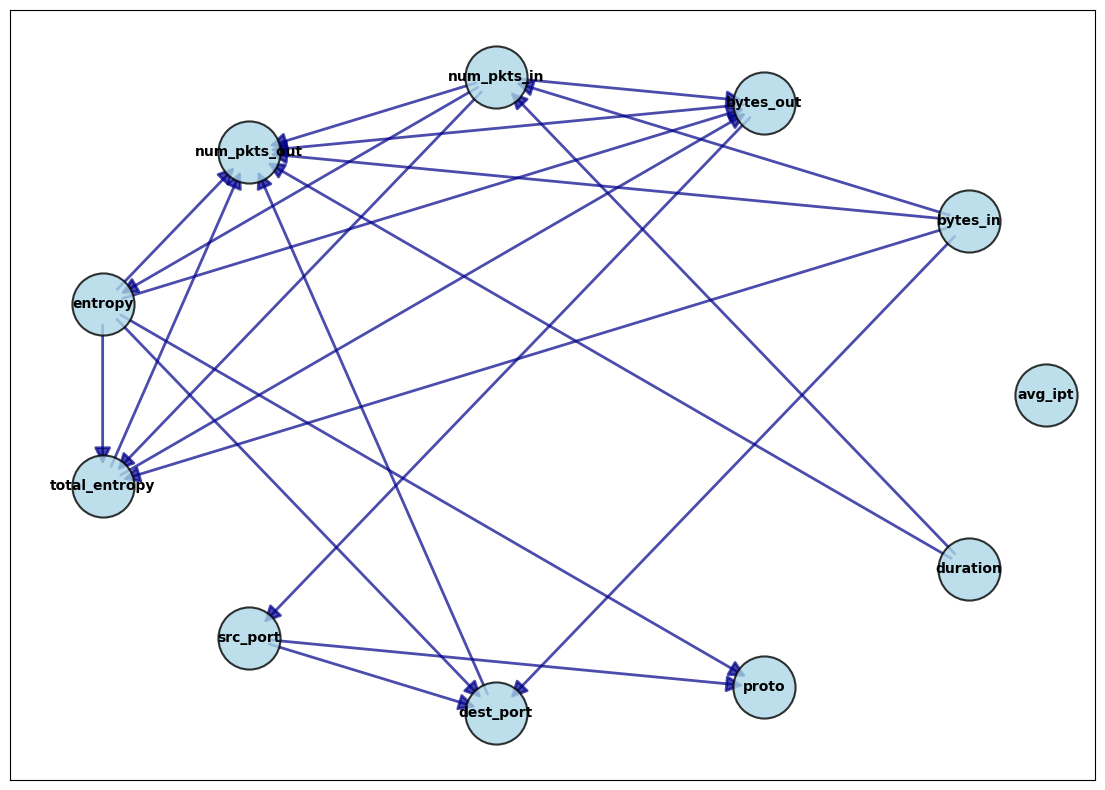

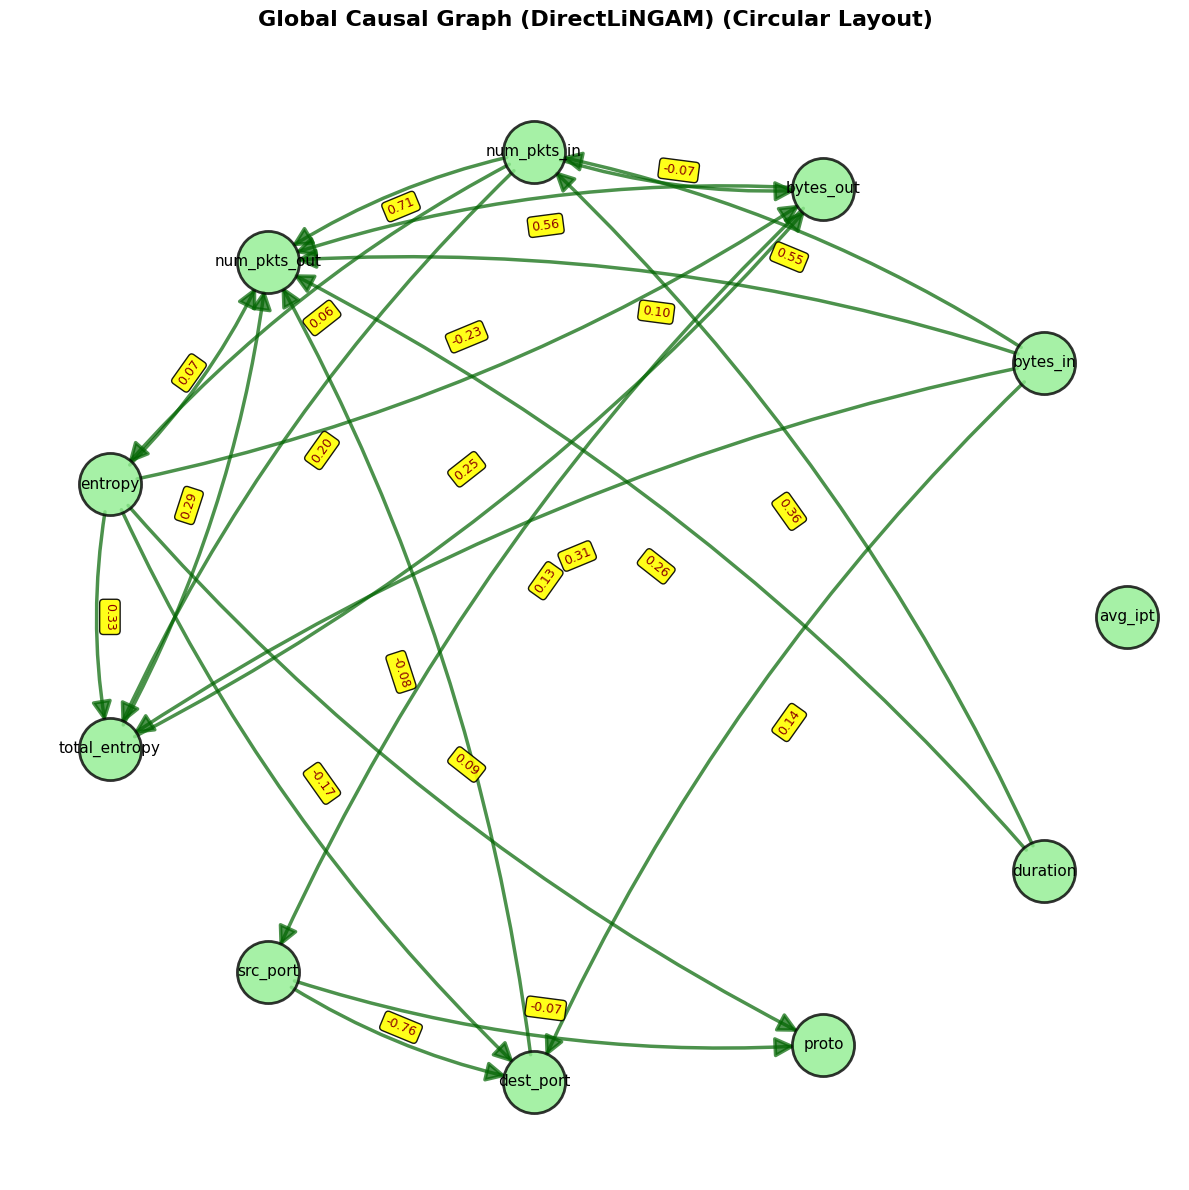

{('bytes_in', 'num_pkts_in'): '0.55', ('bytes_in', 'num_pkts_out'): '0.10', ('bytes_in', 'total_entropy'): '0.26', ('bytes_in', 'src_port'): '-0.05', ('bytes_in', 'dest_port'): '0.20', ('bytes_in', 'duration'): '0.08', ('bytes_out', 'num_pkts_out'): '0.28', ('bytes_out', 'entropy'): '-0.30', ('bytes_out', 'total_entropy'): '0.19', ('bytes_out', 'src_port'): '0.16', ('bytes_out', 'dest_port'): '-0.37', ('bytes_out', 'proto'): '-0.19', ('bytes_out', 'duration'): '0.30', ('num_pkts_in', 'num_pkts_out'): '0.69', ('num_pkts_in', 'entropy'): '0.06', ('num_pkts_in', 'total_entropy'): '0.21', ('num_pkts_in', 'dest_port'): '0.07', ('entropy', 'num_pkts_out'): '-0.10', ('entropy', 'total_entropy'): '0.27', ('entropy', 'src_port'): '0.09', ('entropy', 'dest_port'): '-0.15', ('total_entropy', 'num_pkts_out'): '0.42', ('total_entropy', 'dest_port'): '-0.08', ('src_port', 'dest_port'): '-0.84', ('src_port', 'proto'): '-0.21', ('dest_port', 'num_pkts_out'): '-0.10', ('dest_port', 'proto'): '-0.12', (

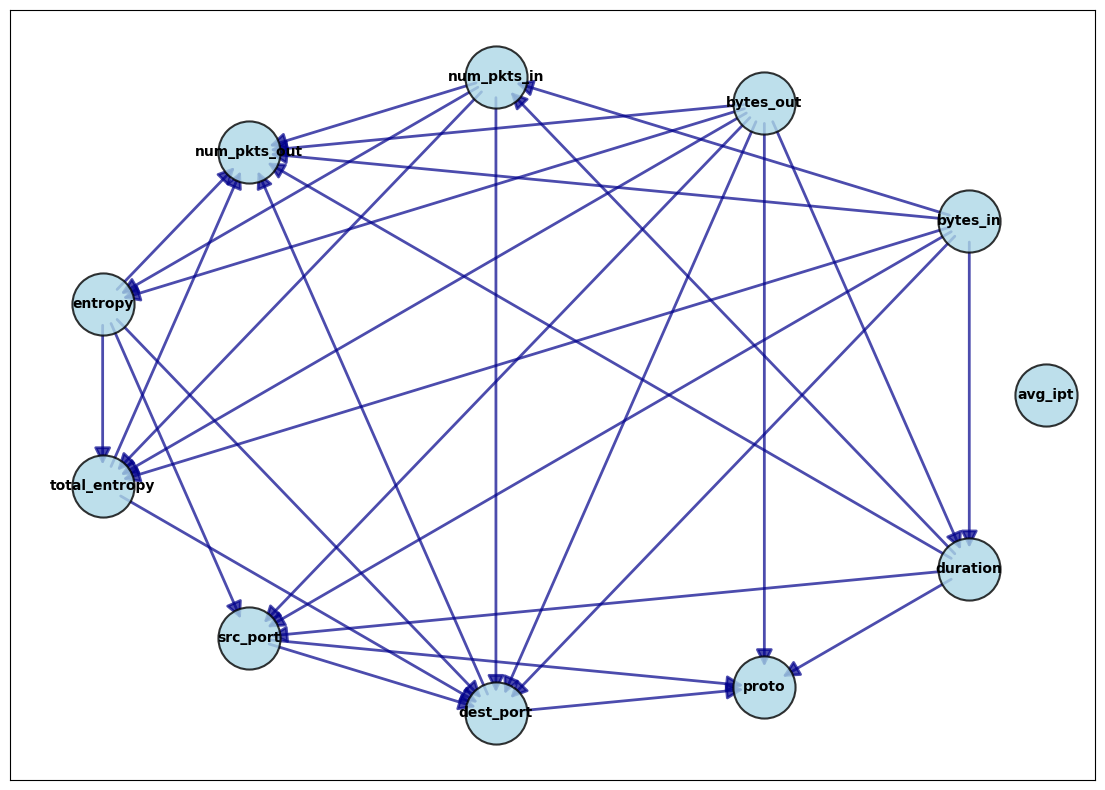

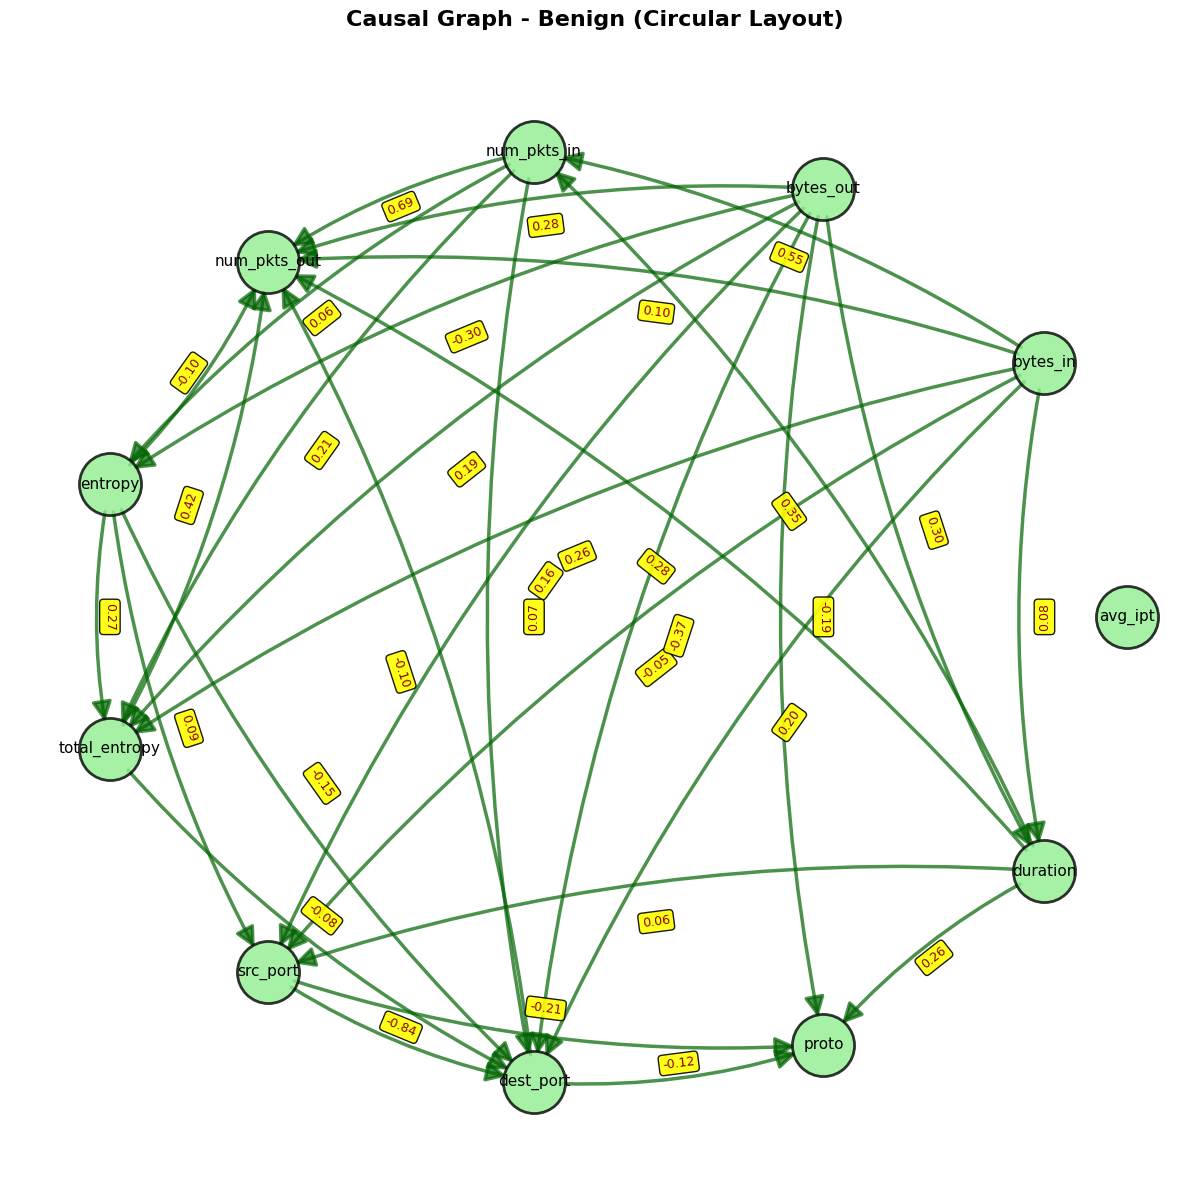

{('bytes_in', 'bytes_out'): '-0.17', ('bytes_in', 'num_pkts_in'): '0.13', ('bytes_in', 'total_entropy'): '1.15', ('bytes_out', 'total_entropy'): '0.87', ('num_pkts_in', 'bytes_out'): '0.29', ('num_pkts_in', 'entropy'): '0.09', ('num_pkts_in', 'total_entropy'): '1.91', ('num_pkts_in', 'dest_port'): '-0.06', ('num_pkts_out', 'bytes_out'): '0.11', ('num_pkts_out', 'num_pkts_in'): '0.46', ('num_pkts_out', 'total_entropy'): '0.42', ('entropy', 'bytes_out'): '-0.43', ('entropy', 'total_entropy'): '4.25', ('entropy', 'dest_port'): '-0.15', ('entropy', 'proto'): '0.10', ('src_port', 'dest_port'): '-0.70', ('duration', 'bytes_out'): '-0.09', ('duration', 'num_pkts_in'): '0.13', ('duration', 'num_pkts_out'): '0.75', ('duration', 'total_entropy'): '-0.28'} 
 {('bytes_in', 'bytes_out'): (np.float64(0.6783343007438059), np.float64(0.7751363682468568)), ('bytes_in', 'num_pkts_in'): (np.float64(0.3994693448626489), np.float64(0.8152311012678195)), ('bytes_in', 'total_entropy'): (np.float64(-0.0091197

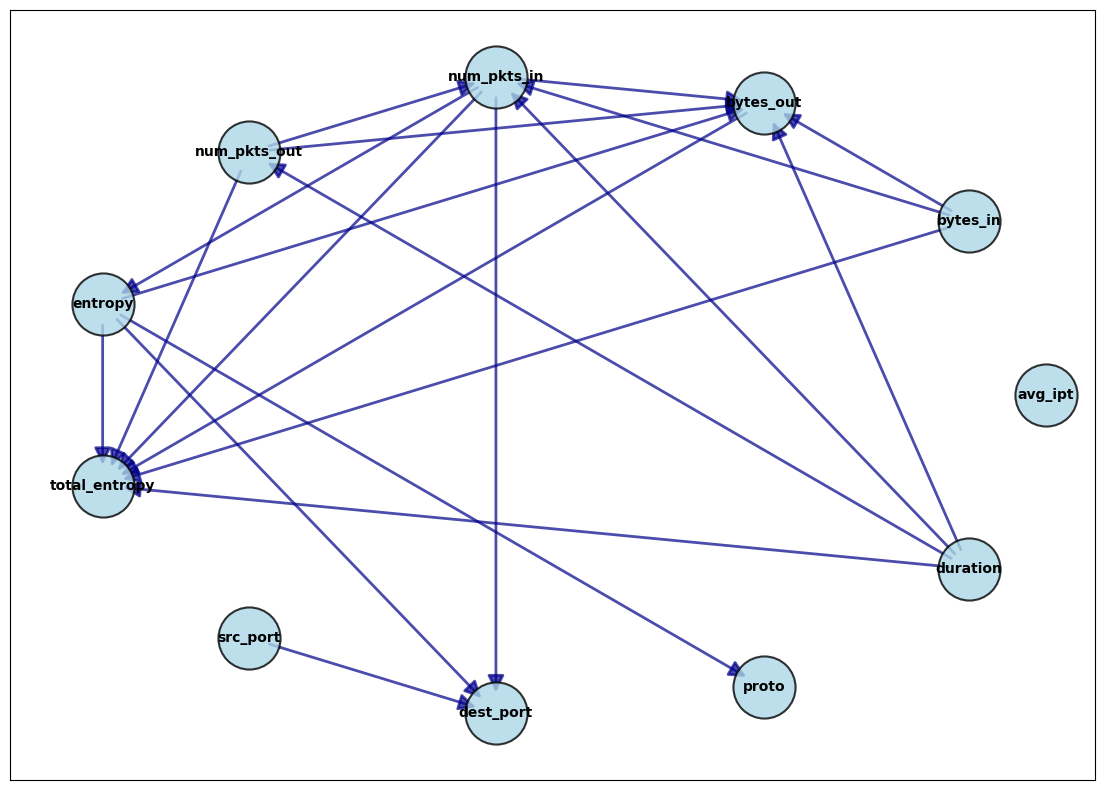

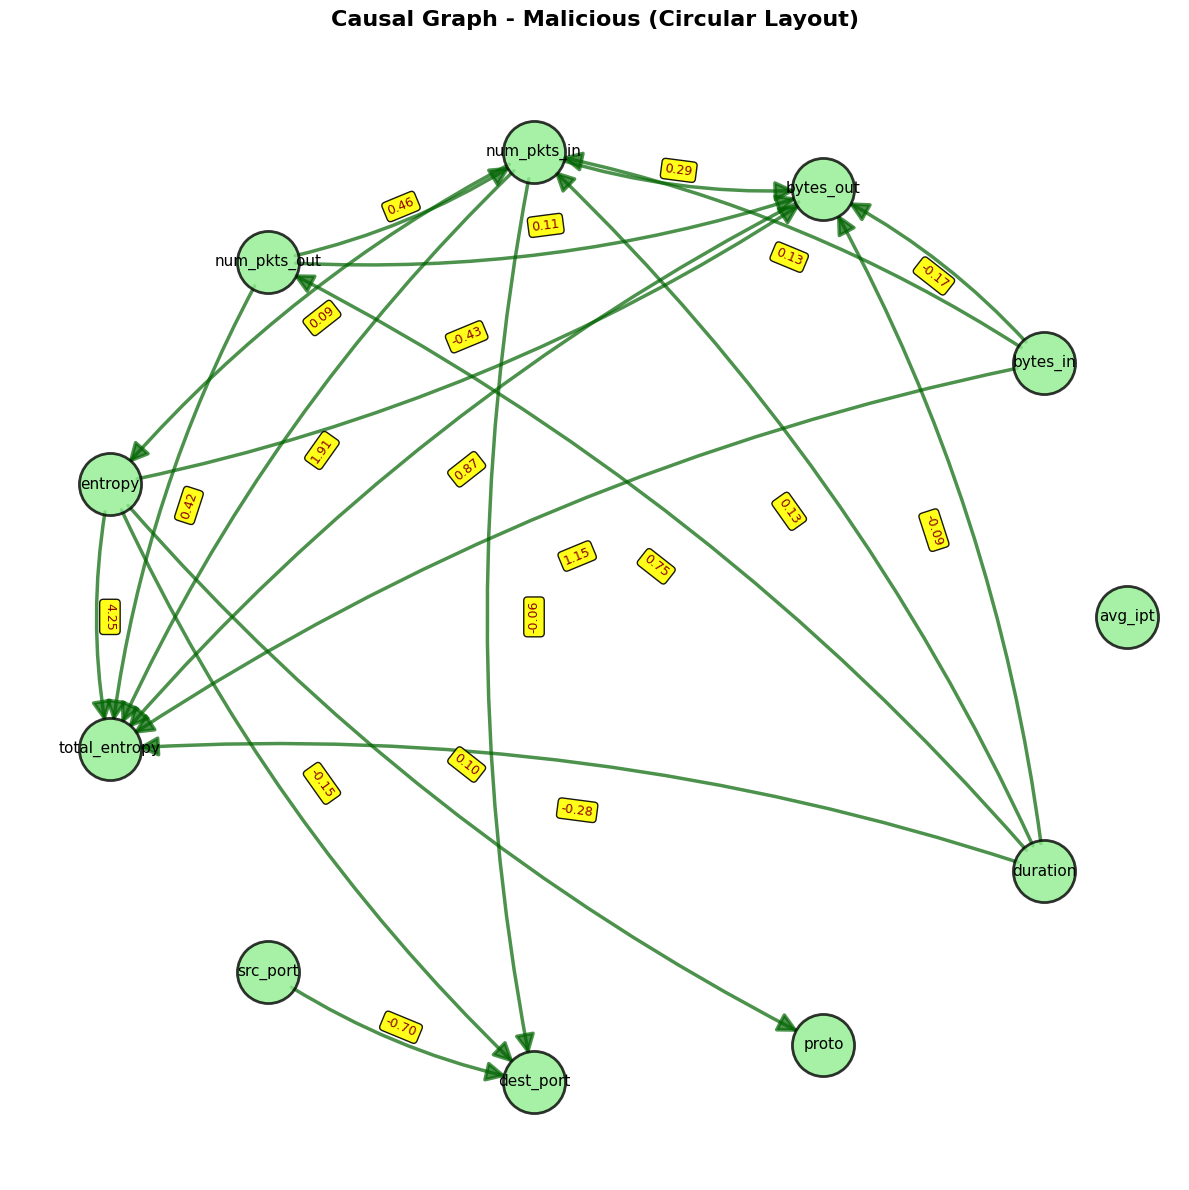

{('bytes_in', 'entropy'): '0.05', ('bytes_out', 'bytes_in'): '-0.13', ('bytes_out', 'total_entropy'): '0.97', ('num_pkts_in', 'bytes_in'): '-0.06', ('num_pkts_in', 'bytes_out'): '0.06', ('num_pkts_in', 'num_pkts_out'): '1.09', ('num_pkts_in', 'entropy'): '0.06', ('num_pkts_in', 'total_entropy'): '0.40', ('num_pkts_out', 'bytes_in'): '0.30', ('num_pkts_out', 'bytes_out'): '0.32', ('num_pkts_out', 'entropy'): '0.09', ('num_pkts_out', 'total_entropy'): '0.33', ('entropy', 'dest_port'): '-0.17', ('entropy', 'proto'): '0.09', ('total_entropy', 'bytes_in'): '0.28', ('src_port', 'dest_port'): '-0.73', ('src_port', 'proto'): '-0.17', ('duration', 'bytes_in'): '-0.11', ('duration', 'bytes_out'): '-0.08', ('duration', 'num_pkts_in'): '0.19', ('duration', 'num_pkts_out'): '0.57', ('duration', 'total_entropy'): '0.19'} 
 {('bytes_in', 'entropy'): (np.float64(-0.00911972544886995), np.float64(0.46118668067895996)), ('bytes_out', 'bytes_in'): (np.float64(0.6783343007438059), np.float64(0.77513636824

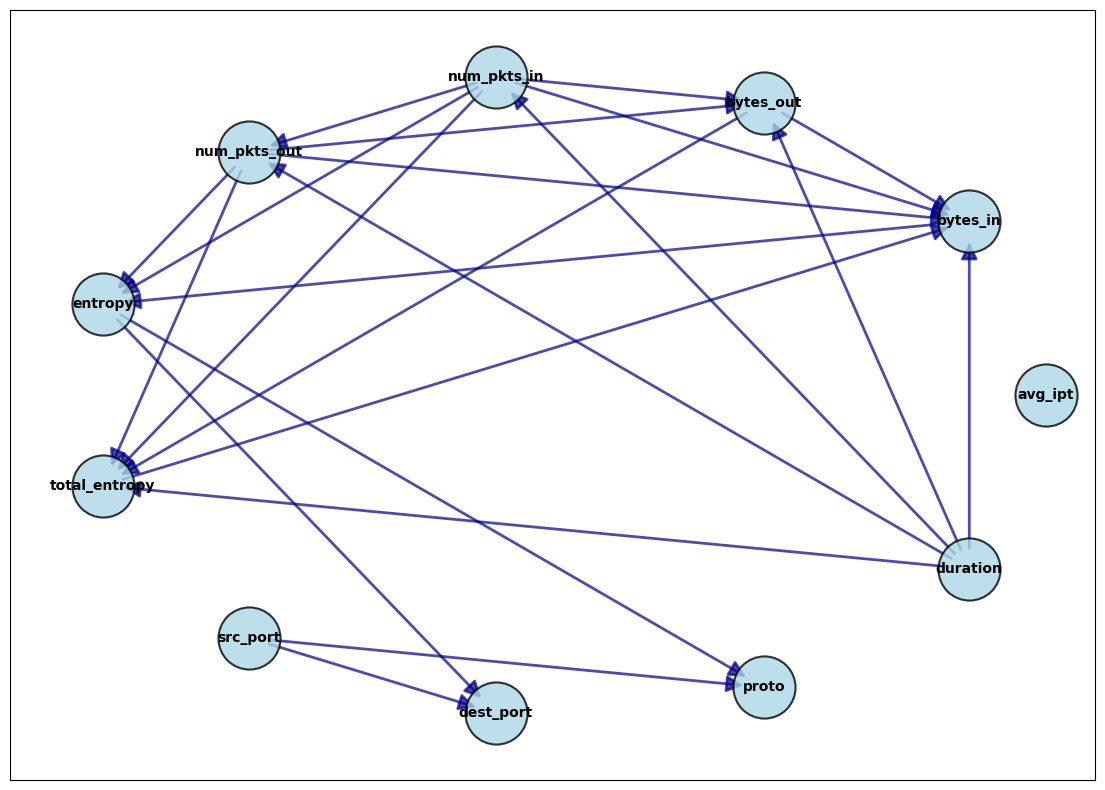

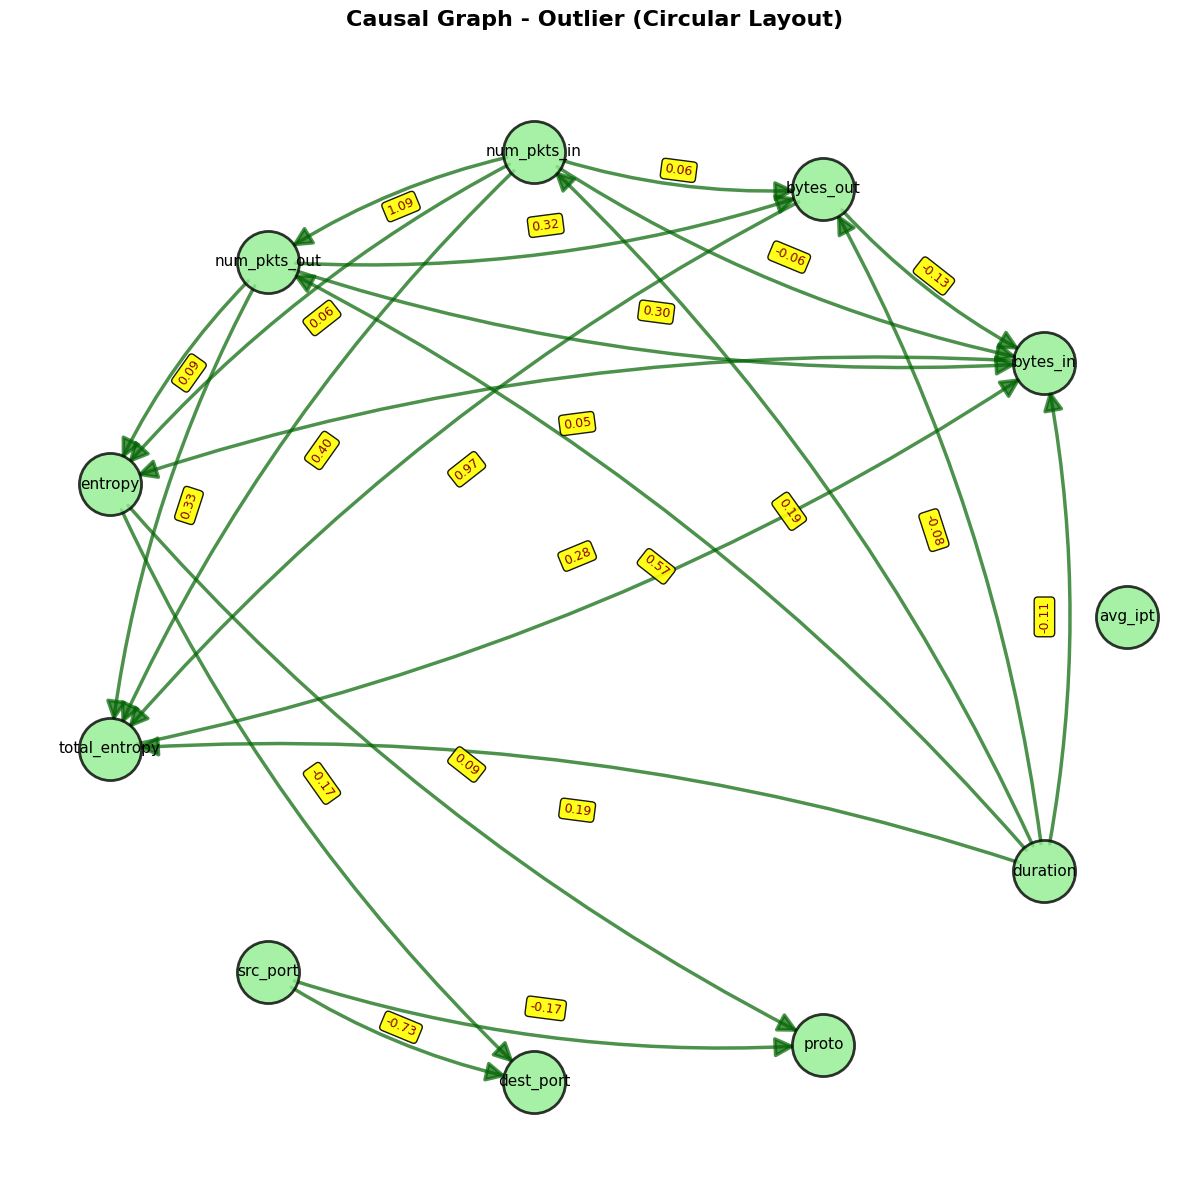

In [ ]:
# === Step 3 (Updated): Plot graphs per class with improved spacing and visibility ===
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

results_path = Path("/content/drive/MyDrive/Data-science-project/journal-article/lingam_results")
edge_threshold = 0.05

def load_adjacency(name):
    path = results_path / name
    if not path.exists():
        print(f"Missing {name}")
        return None
    return pd.read_csv(path, index_col=0)

def plot_causal_graph(adj_df, title, threshold=0.05):
    G = nx.DiGraph()
    cols = adj_df.columns

    # Add all nodes first to ensure they exist
    G.add_nodes_from(cols)

    # Build the graph edges
    for i in range(len(cols)):
        for j in range(len(cols)):
            w = adj_df.iloc[i, j]
            if abs(w) > threshold:
                G.add_edge(cols[i], cols[j], weight=w)

    # Check if graph has nodes
    if len(G.nodes()) == 0:
        print(f"No nodes found in graph for {title}")
        return

    # Create larger figure with better aspect ratio
    plt.figure(figsize=(14, 10))

    # Use multiple layout attempts to find the best spacing
    best_pos = None
    max_min_distance = 0

    # Try different layout algorithms and seeds - avoid Kamada-Kawai due to negative weights
    layout_functions = [
        lambda g, s: nx.spring_layout(g, k=3, iterations=50, seed=s),
        lambda g, s: nx.spring_layout(g, k=2, iterations=100, seed=s),
        lambda g, s: nx.spring_layout(g, k=4, iterations=30, seed=s),
        lambda g, s: nx.circular_layout(g),
        lambda g, s: nx.shell_layout(g),
    ]

    for seed in [42, 123, 456, 789, 999]:
        for layout_func in layout_functions:
            try:
                pos = layout_func(G, seed)

                # Ensure all nodes have positions
                if len(pos) == len(G.nodes()) and all(node in pos for node in G.nodes()):
                    # Calculate minimum distance between nodes
                    if len(pos) > 1:
                        distances = []
                        pos_values = list(pos.values())
                        for i in range(len(pos_values)):
                            for j in range(i + 1, len(pos_values)):
                                dist = np.sqrt((pos_values[i][0] - pos_values[j][0])**2 +
                                             (pos_values[i][1] - pos_values[j][1])**2)
                                distances.append(dist)

                        min_distance = min(distances) if distances else 0
                        if min_distance > max_min_distance:
                            max_min_distance = min_distance
                            best_pos = pos
            except Exception as e:
                continue

    # Use the best position found, or create manual layout
    if best_pos is None or len(best_pos) != len(G.nodes()):
        # Create manual circular layout as final fallback
        nodes = list(G.nodes())
        best_pos = {}
        if len(nodes) == 1:
            best_pos[nodes[0]] = (0, 0)
        else:
            angle_step = 2 * np.pi / len(nodes)
            radius = max(2, len(nodes) * 0.3)  # Scale radius with number of nodes
            for i, node in enumerate(nodes):
                angle = i * angle_step
                best_pos[node] = (radius * np.cos(angle), radius * np.sin(angle))

    # Verify all nodes have positions before drawing
    all_nodes = set(G.nodes())
    pos_nodes = set(best_pos.keys())

    if all_nodes != pos_nodes:
        print(f"Position mismatch - Graph nodes: {all_nodes}")
        print(f"Position nodes: {pos_nodes}")
        print(f"Missing nodes: {all_nodes - pos_nodes}")
        return


    # Only proceed if we have valid positions for all nodes
    try:
        # Draw nodes with better visibility
        nx.draw_networkx_nodes(G, best_pos,
                              node_color='lightblue',
                              node_size=2000,  # Larger nodes
                              alpha=0.8,
                              edgecolors='black',  # Node borders for better definition
                              linewidths=1.5)

        # Draw edges with improved arrow properties
        nx.draw_networkx_edges(G, best_pos,
                              edge_color='darkblue',
                              arrows=True,
                              arrowsize=25,  # Larger arrows
                              arrowstyle='-|>',  # More visible arrow style
                              width=2,  # Thicker edges
                              alpha=0.7,
                              min_target_margin=15,  # Space between arrow and node
                              min_source_margin=15)

        # Draw labels with better positioning
        nx.draw_networkx_labels(G, best_pos,
                               font_size=10,
                               font_weight='bold',
                               font_color='black')

        # Draw edge labels with better positioning and styling
        edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}

        if edge_labels:  # Only draw edge labels if there are edges
            # Adjust edge label positions to avoid overlap with arrows
            edge_label_pos = {}
            for (u, v) in edge_labels.keys():
              x1, y1 = best_pos[u]
              x2, y2 = best_pos[v]
              edge_label_pos[(u, v)] = ((x1 + x2) / 2 + 0.05, (y1 + y2) / 2 + 0.05)

            #edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
            print(edge_labels, '\n', edge_label_pos)
            nx.draw_networkx_edge_labels(G, edge_label_pos,
                                        edge_labels=edge_labels,
                                        font_size=9,
                                        font_color='red',
                                        font_weight='bold',
                                        bbox=dict(boxstyle='round,pad=0.2',
                                                 facecolor='white',
                                                 alpha=0.8,
                                                 edgecolor='gray'))

        plt.title(title, fontsize=16, fontweight='bold', pad=20)
        plt.axis('off')

        # Adjust margins to prevent clipping
        plt.tight_layout()
        plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.05)

        plt.show()

    except Exception as e:
        print(f"Error drawing graph: {e}")
        print(f"Graph has {len(G.nodes())} nodes and {len(G.edges())} edges")
        print(f"Nodes: {list(G.nodes())}")
        return

def plot_causal_graph_circular(adj_df, title, threshold=0.05):
    """Alternative circular layout for better spacing when spring layout is too crowded"""
    G = nx.DiGraph()
    cols = adj_df.columns

    # Add all nodes first to ensure they exist
    G.add_nodes_from(cols)

    # Build the graph edges
    for i in range(len(cols)):
        for j in range(len(cols)):
            w = adj_df.iloc[i, j]
            if abs(w) > threshold:
                G.add_edge(cols[i], cols[j], weight=w)

    # Check if graph has nodes
    if len(G.nodes()) == 0:
        print(f"No nodes found in graph for {title}")
        return

    plt.figure(figsize=(12, 12))

    # Use circular layout for maximum spacing with error handling
    try:
        pos = nx.circular_layout(G, scale=2)
    except Exception as e:
        print(f"Circular layout failed: {e}")
        # Fallback to shell layout
        try:
            pos = nx.shell_layout(G)
        except:
            # Final fallback - manual positioning
            nodes = list(G.nodes())
            pos = {}
            angle_step = 2 * np.pi / len(nodes)
            for i, node in enumerate(nodes):
                angle = i * angle_step
                pos[node] = (2 * np.cos(angle), 2 * np.sin(angle))

    # Ensure all nodes have positions
    missing_nodes = [node for node in G.nodes() if node not in pos]
    if missing_nodes:
        print(f"Warning: Missing positions for nodes in circular layout: {missing_nodes}")
        for i, node in enumerate(missing_nodes):
            pos[node] = (i * 0.2, i * 0.2)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos,
                          node_color='lightgreen',
                          node_size=2000,
                          alpha=0.8,
                          edgecolors='black',
                          linewidths=2)

    # Draw edges with curved arrows to avoid overlap
    nx.draw_networkx_edges(G, pos,
                          edge_color='darkgreen',
                          arrows=True,
                          arrowsize=30,
                          arrowstyle='-|>',
                          width=2.5,
                          alpha=0.7,
                          connectionstyle="arc3,rad=0.1",  # Curved edges
                          min_target_margin=20,
                          min_source_margin=20)

    # Draw labels
    nx.draw_networkx_labels(G, pos,
                           font_size=11)
                           #font_weight='bold')

    # Draw edge labels
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos,
                                edge_labels=edge_labels,
                                font_size=9,
                                font_color='darkred',
                                #font_weight='bold',
                                bbox=dict(boxstyle='round,pad=0.3',
                                         facecolor='yellow',
                                         alpha=0.9))

    plt.title(f"{title} (Circular Layout)", fontsize=16, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- Plot Global ---
adj_direct = load_adjacency("global_direct_lingam_adjacency.csv")
if adj_direct is not None:
    plot_causal_graph(adj_direct, "Global Causal Graph (DirectLiNGAM)", threshold=edge_threshold)
    # Also try circular layout as alternative
    plot_causal_graph_circular(adj_direct, "Global Causal Graph (DirectLiNGAM)", threshold=edge_threshold)

# --- Per-Class Graphs ---
for cls in ["benign_only_direct_lingam_adjacency.csv",
            "malicious_only_direct_lingam_adjacency.csv",
            "outlier_only_direct_lingam_adjacency.csv"]:
    adj_cls = load_adjacency(cls)
    if adj_cls is not None:
        class_name = cls.replace("_only_direct_lingam_adjacency.csv", "")
        plot_causal_graph(adj_cls, f"Causal Graph - {class_name.title()}", threshold=edge_threshold)
        # Also plot circular version for comparison
        plot_causal_graph_circular(adj_cls, f"Causal Graph - {class_name.title()}", threshold=edge_threshold)

## the best graph

Graph saved to: /content/drive/MyDrive/Data-science-project/journal-article/lingam_results/causal-graphs/global_causal_graph_directlingamthreshold_0.15.png


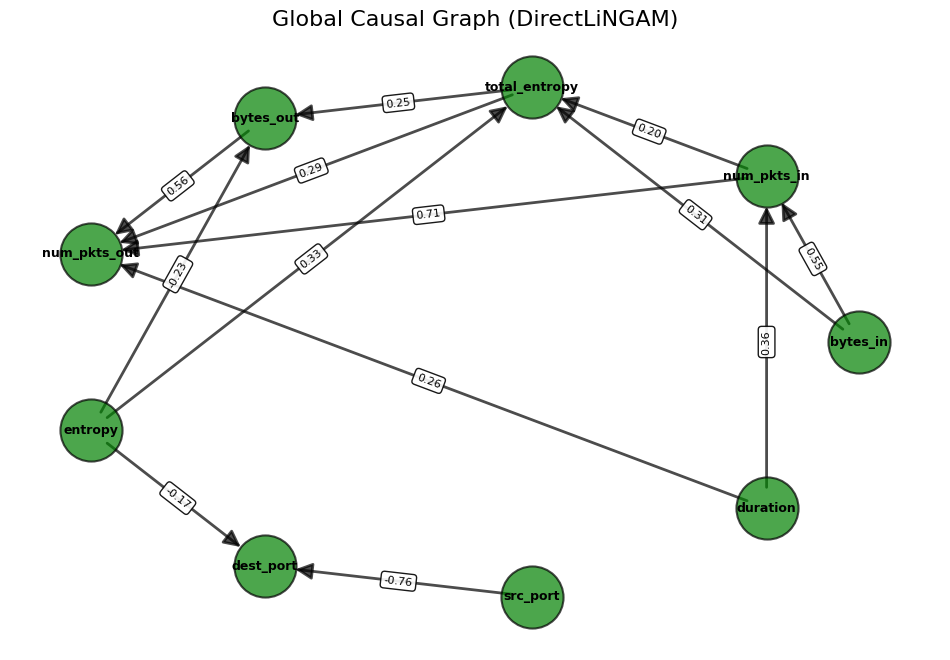

Graph saved to: /content/drive/MyDrive/Data-science-project/journal-article/lingam_results/causal-graphs/causal_graph_-_benignthreshold_0.15.png


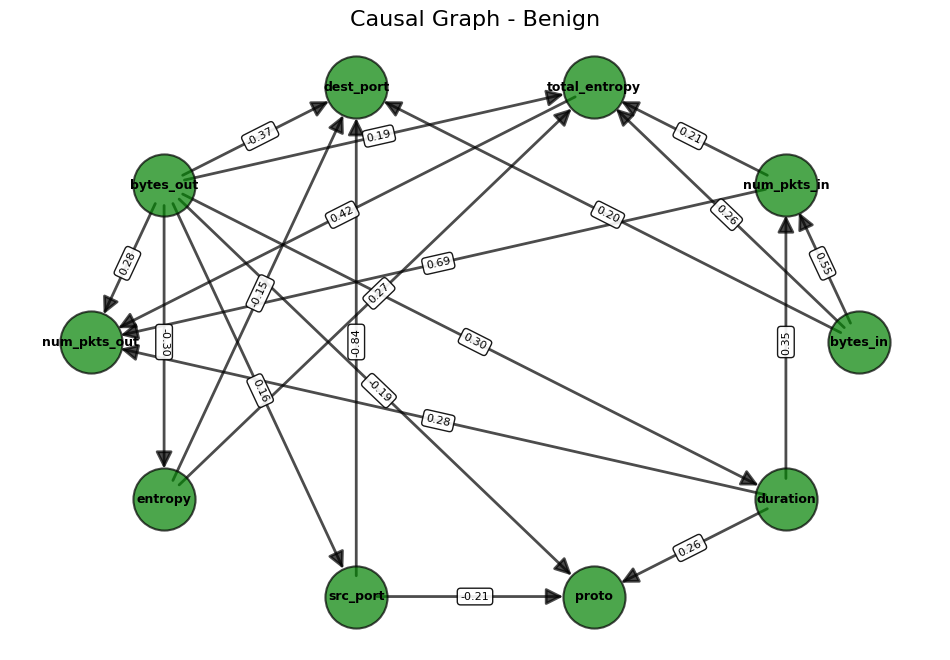

Graph saved to: /content/drive/MyDrive/Data-science-project/journal-article/lingam_results/causal-graphs/causal_graph_-_maliciousthreshold_0.15.png


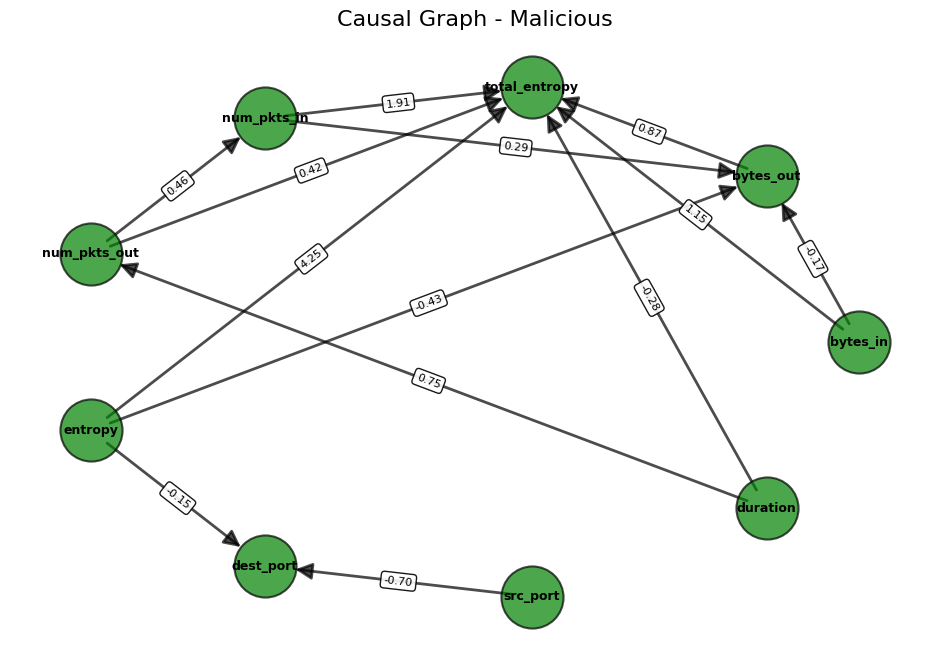

Graph saved to: /content/drive/MyDrive/Data-science-project/journal-article/lingam_results/causal-graphs/causal_graph_-_outlierthreshold_0.15.png


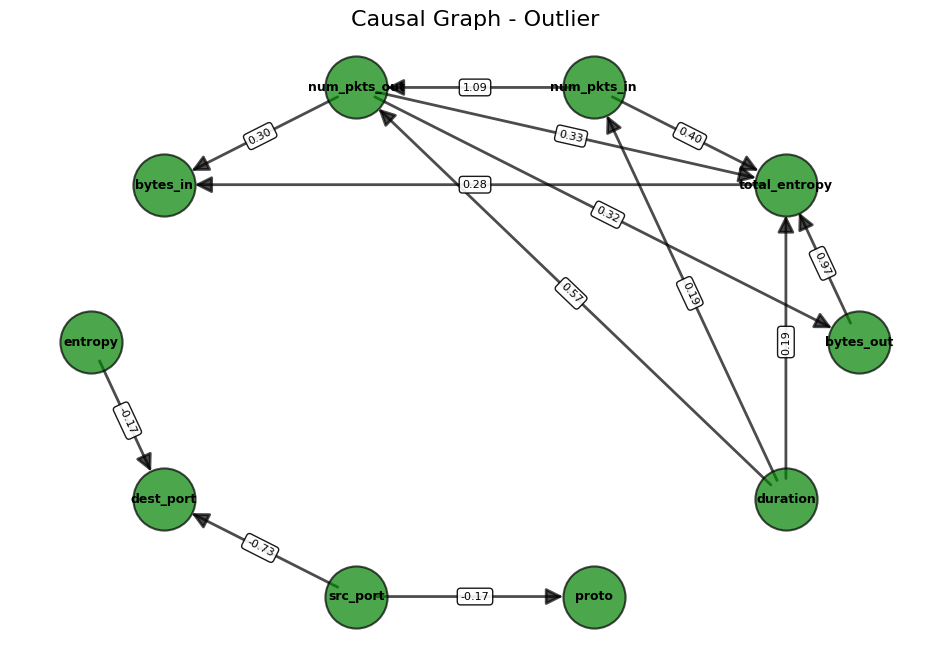

Graph saved to: /content/drive/MyDrive/Data-science-project/journal-article/lingam_results/causal-graphs/global_causal_graph_directlingamthreshold_0.15.png


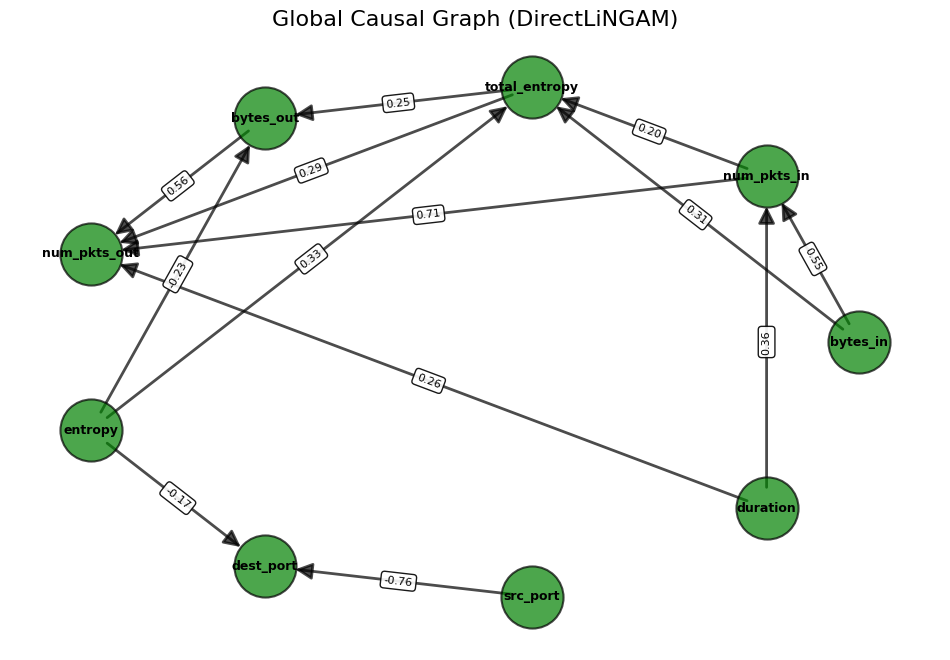

Graph saved to: /content/drive/MyDrive/Data-science-project/journal-article/lingam_results/causal-graphs/global_causal_graph_ica-lingamthreshold_0.15.png


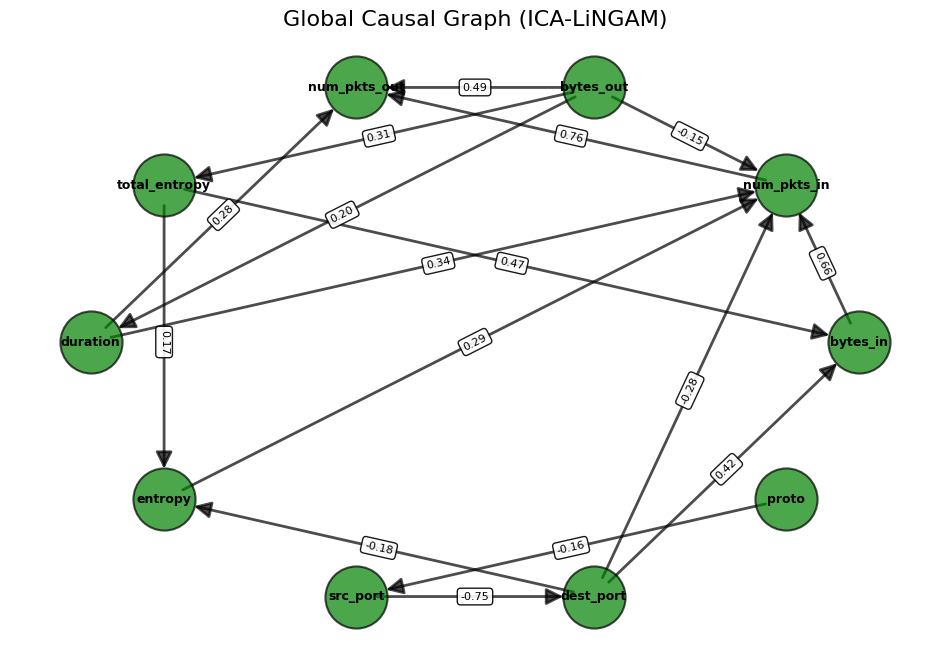

Saved difference matrix (Direct - ICA) to: /content/drive/MyDrive/Data-science-project/journal-article/lingam_results/direct_vs_ica_diff.csv


avg_ipt  bytes_in  bytes_out  num_pkts_in  num_pkts_out  \
avg_ipt       0.000000  0.000000   0.000000     0.000000      0.000000   
bytes_in      0.000000  0.000000  -0.039775    -0.116524     -0.027899   
bytes_out     0.000000  0.068734   0.000000     0.153186      0.070581   
num_pkts_in  -0.005587  0.000000  -0.072175     0.000000     -0.054497   
num_pkts_out -0.000019  0.000000   0.000000     0.000000      0.000000   

               entropy  total_entropy  src_port  dest_port     proto  duration  
avg_ipt       0.000000       0.000000  0.000000   0.000000  0.000000  0.000000  
bytes_in     -0.023482       0.305671 -0.016923   0.140199  0.009269  0.043470  
bytes_out     0.144955      -0.309685  0.010576   0.027746 -0.007252 -0.202021  
num_pkts_in   0.063310       0.204211 -0.022664  -0.044063 -0.010347  0.000000  
num_pkts_out  0.000000       0.000000  0.000000   0.000000 -0.011217  0.000000

Graph saved to: /content/drive/MyDrive/Data-science-project/journal-article/lingam_results/causal-graphs/benign_vs_malicious_multi-group_lingamthreshold_0.15.png


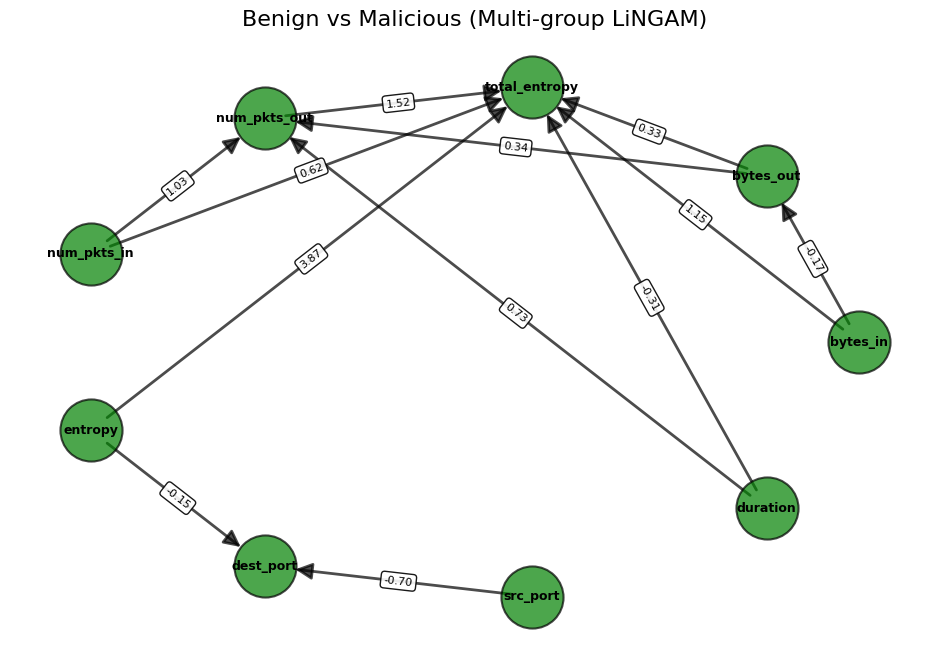

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

results_path = Path("/content/drive/MyDrive/Data-science-project/journal-article/lingam_results")
edge_threshold = 0.15

def load_adjacency(name):
    path = results_path / name
    if not path.exists():
        print(f"Missing {name}")
        return None
    return pd.read_csv(path, index_col=0)

def plot_causal_graph(adj_df, title, threshold=0.05):
    G = nx.DiGraph()
    cols = adj_df.columns
    for i in range(len(cols)):
        for j in range(len(cols)):
            w = adj_df.iloc[i, j]
            if abs(w) > threshold:
                G.add_edge(cols[i], cols[j], weight=w)

    plt.figure(figsize=(12, 8)) # Increase figure size for better spacing

    # --- Node Positioning and Layout ---
    try:
        # Try circular layout first
        pos = nx.circular_layout(G, scale=1.5)
    except Exception as e:
        print(f"Circular layout failed for '{title}': {e}")
        try:
            # Fallback to shell layout
            pos = nx.shell_layout(G)
        except Exception as e:
            print(f"Shell layout failed for '{title}': {e}")
            # Final fallback - manual circular positioning
            nodes = list(G.nodes())
            if len(nodes) > 0:
                pos = {}
                angle_step = 2 * np.pi / len(nodes)
                for i, node in enumerate(nodes):
                    angle = i * angle_step
                    pos[node] = (2 * np.cos(angle), 2 * np.sin(angle))
            else:
                pos = {}

    # If the graph has no nodes after filtering, pos might be empty. Handle this.
    if not pos:
        print(f"No nodes to plot for '{title}' after applying threshold.")
        plt.close() # Close the empty figure
        return

    # --- Draw Nodes ---
    nx.draw_networkx_nodes(G, pos, node_color='green', node_size=2000, alpha=0.7, edgecolors='black', linewidths=1.5)

    # --- Draw Edges ---
    nx.draw_networkx_edges(G, pos, edge_color='black', arrows=True, arrowsize=25, arrowstyle='-|>',
                           alpha=0.7, width=2,
                           min_target_margin=22,
                           min_source_margin=15)

    # --- Draw Labels ---
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')

    # --- Edge Labels ---
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, bbox=dict(facecolor='white', alpha=0.9, edgecolor='black',
                                                                                         boxstyle='round,pad=0.3'))

    plt.title(title, fontsize=16)
    plt.axis('off')

    # --- Display the graph ---
    #plt.show() # This will open the plot window

    # --- Save the graph to a file ---
    save_dir = results_path / "causal-graphs"
    save_dir.mkdir(parents=True, exist_ok=True)

    # Sanitize title to create a valid filename
    filename = title.replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_").lower() + f'threshold_{threshold}' + ".png"
    save_path = save_dir / filename
    plt.savefig(save_path, bbox_inches='tight', dpi=300) # Save FIRST
    print(f"Graph saved to: {save_path}")

    plt.show() # Then show
    plt.close() # Then close to free memory
    #plt.savefig(save_path, bbox_inches='tight', dpi=300) # Save with tight bounding box and high DPI
    #print(f"Graph saved to: {save_path}")
    #plt.close() # Close the plot to free memory (important when looping through many plots)

# --- Plot Global ---
adj_direct = load_adjacency("global_direct_lingam_adjacency.csv")
if adj_direct is not None:
    plot_causal_graph(adj_direct, "Global Causal Graph (DirectLiNGAM)", threshold=edge_threshold)

# --- Per-Class Graphs ---
for cls in ["benign_only_direct_lingam_adjacency.csv",
            "malicious_only_direct_lingam_adjacency.csv",
            "outlier_only_direct_lingam_adjacency.csv"]:
    adj_cls = load_adjacency(cls)
    if adj_cls is not None:
        class_name = cls.replace("_only_direct_lingam_adjacency.csv", "")
        plot_causal_graph(adj_cls, f"Causal Graph - {class_name.title()}", threshold=edge_threshold)

# -------------------- Load Direct & ICA --------------------
adj_direct = load_adjacency("global_direct_lingam_adjacency.csv")
adj_ica    = load_adjacency("global_ica_lingam_adjacency.csv")


# -------------------- Plot causal graphs --------------------
plot_causal_graph(adj_direct, "Global Causal Graph (DirectLiNGAM)", threshold=edge_threshold)
plot_causal_graph(adj_ica, "Global Causal Graph (ICA-LiNGAM)", threshold=edge_threshold)

# -------------------- Compare Direct vs ICA --------------------
diff_matrix = adj_direct - adj_ica
diff_path = results_path / "direct_vs_ica_diff.csv"
diff_matrix.to_csv(diff_path)
print(f"Saved difference matrix (Direct - ICA) to: {diff_path}")
display(diff_matrix.head())

# -------------------- Multi-group Comparison --------------------
multi_group_file = results_path / "multi_group_benign_malicious_mg_direct_lingam_adjacency.csv"
if multi_group_file.exists():
    adj_mg = load_adjacency(multi_group_file)
    plot_causal_graph(adj_mg, "Benign vs Malicious (Multi-group LiNGAM)", threshold=edge_threshold)
else:
    print("No multi-group results found.")

# Step 2: Apply LiNGAM Approaches (BATCHES)

In [ ]:
!pip -q install lingam joblib

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from joblib import load
from lingam import DirectLiNGAM, ICALiNGAM, MultiGroupDirectLiNGAM
import os

# -------------------- Config --------------------
preprocessed_path = '/content/drive/MyDrive/Data-science-project/journal-article/combined_dataset_preprocessed.csv'
scaler_path       = '/content/drive/MyDrive/Data-science-project/journal-article/standard_scaler.joblib'
out_dir           = Path('/content/drive/MyDrive/Data-science-project/journal-article/lingam_results_full')
mm_dir            = Path('/content/drive/MyDrive/Data-science-project/journal-article/_memmaps')
mm_dir.mkdir(parents=True, exist_ok=True)
out_dir.mkdir(parents=True, exist_ok=True)

chunksize = 200_000  # adjust for your RAM / IO
random_state = 42
edge_threshold = 0.0  # prune small absolute weights if desired

label_col = 'label_encoded'

In [ ]:
def adjacency_to_edgelist(B: np.ndarray, cols, thresh=0.0):
    edges = []
    for i in range(B.shape[0]):
        for j in range(B.shape[1]):
            w = B[i, j]
            if abs(w) > thresh:
                edges.append((cols[i], cols[j], float(w)))
    return pd.DataFrame(edges, columns=['source', 'target', 'weight'])

def save_results(prefix, model_name, adj, order=None, cols=None):
    adj_df = pd.DataFrame(adj, index=cols, columns=cols)
    adj_path = out_dir / f'{prefix}_{model_name}_adjacency.csv'
    adj_df.to_csv(adj_path, index=True)
    print(f"Saved adjacency to: {adj_path}")

    edges_df = adjacency_to_edgelist(adj, cols, edge_threshold)
    edges_path = out_dir / f'{prefix}_{model_name}_edges.csv'
    edges_df.to_csv(edges_path, index=False)
    print(f"Saved edge list to: {edges_path} (kept {len(edges_df)} edges)")

    if order is not None:
        order_df = pd.DataFrame({'variable': [cols[i] for i in order], 'position': range(len(order))})
        order_path = out_dir / f'{prefix}_{model_name}_order.csv'
        order_df.to_csv(order_path, index=False)
        print(f"Saved causal order to: {order_path}")

In [ ]:
first_chunk = pd.read_csv(preprocessed_path, nrows=5)
if label_col not in first_chunk.columns:
    raise ValueError(f"'{label_col}' not found in the preprocessed file.")
feature_cols = [c for c in first_chunk.columns if c != label_col]
p = len(feature_cols)
print("Features:", feature_cols)

Features: ['avg_ipt', 'bytes_in', 'bytes_out', 'num_pkts_in', 'num_pkts_out', 'entropy', 'total_entropy', 'src_port', 'dest_port', 'proto', 'duration']


In [ ]:
# -------------------- Pass 1: Count rows (global + per label) --------------------
print("Pass 1/2: Counting rows...")
n_total = 0
n_benign = n_malicious = n_outlier = 0

for chunk in pd.read_csv(preprocessed_path, chunksize=chunksize, usecols=feature_cols+[label_col]):
    n_total += len(chunk)
    n_benign    += (chunk[label_col] == 0).sum()
    n_malicious += (chunk[label_col] == 1).sum()
    n_outlier   += (chunk[label_col] == 2).sum()

print(f"Total rows: {n_total:,} (benign={n_benign:,}, malicious={n_malicious:,}, outlier={n_outlier:,})")


Pass 1/2: Counting rows...
Total rows: 42,729,820 (benign=24,643,469, malicious=10,022,585, outlier=8,063,766)


In [ ]:
# -------------------- Create memmaps --------------------
mm_all_path = mm_dir / 'X_all.dat'
X_all = np.memmap(mm_all_path, dtype='float32', mode='w+', shape=(n_total, p))

X_b_path = mm_dir / 'X_benign.dat'
X_m_path = mm_dir / 'X_malicious.dat'
X_o_path = mm_dir / 'X_outlier.dat'

X_b = np.memmap(X_b_path, dtype='float32', mode='w+', shape=(n_benign, p)) if n_benign > 0 else None
X_m = np.memmap(X_m_path, dtype='float32', mode='w+', shape=(n_malicious, p)) if n_malicious > 0 else None
X_o = np.memmap(X_o_path, dtype='float32', mode='w+', shape=(n_outlier, p)) if n_outlier > 0 else None


In [ ]:
# -------------------- Pass 2: Fill memmaps --------------------
print("Pass 2/2: Streaming into memmaps...")
i_all = i_b = i_m = i_o = 0

for chunk in pd.read_csv(preprocessed_path, chunksize=chunksize, usecols=feature_cols+[label_col]):
    X_chunk = chunk[feature_cols].astype('float32').to_numpy()
    y_chunk = chunk[label_col].to_numpy()

    # all
    X_all[i_all:i_all+len(chunk), :] = X_chunk
    i_all += len(chunk)

    # per label
    if X_b is not None:
        mask = (y_chunk == 0)
        if mask.any():
            n = mask.sum()
            X_b[i_b:i_b+n, :] = X_chunk[mask]
            i_b += n
    if X_m is not None:
        mask = (y_chunk == 1)
        if mask.any():
            n = mask.sum()
            X_m[i_m:i_m+n, :] = X_chunk[mask]
            i_m += n
    if X_o is not None:
        mask = (y_chunk == 2)
        if mask.any():
            n = mask.sum()
            X_o[i_o:i_o+n, :] = X_chunk[mask]
            i_o += n

# Flush to disk
del X_chunk, y_chunk
X_all.flush()
if X_b is not None: X_b.flush()
if X_m is not None: X_m.flush()
if X_o is not None: X_o.flush()

# Reopen as read-only to avoid accidental writes
X_all = np.memmap(mm_all_path, dtype='float32', mode='r', shape=(n_total, p))
X_b   = np.memmap(X_b_path, dtype='float32', mode='r', shape=(n_benign, p)) if n_benign > 0 else None
X_m   = np.memmap(X_m_path, dtype='float32', mode='r', shape=(n_malicious, p)) if n_malicious > 0 else None
X_o   = np.memmap(X_o_path, dtype='float32', mode='r', shape=(n_outlier, p)) if n_outlier > 0 else None

print("Memmaps ready.")

Pass 2/2: Streaming into memmaps...
Memmaps ready.


## 2.1 DirectLiNGAM
Goal: Discover the direct causal ordering of features (e.g., does num_pkts_in → bytes_in → entropy?).

Use the preprocessed numeric dataset without labels.

Fit DirectLiNGAM and extract the causal ordering and adjacency matrix (causal strengths).

Why: To get a baseline linear causal structure for all traffic.

In [ ]:
print("\n=== DirectLiNGAM (global, full data) ===")
direct_model = DirectLiNGAM(random_state=random_state)
direct_model.fit(X_all)
B_direct = direct_model.adjacency_matrix_
order_direct = direct_model.causal_order_
save_results('global_full', 'direct_lingam', B_direct, order_direct, feature_cols)


=== DirectLiNGAM (global, full data) ===


/usr/local/lib/python3.11/dist-packages/lingam/direct_lingam.py:159: RuntimeWarning: overflow encountered in cosh
  np.mean(np.log(np.cosh(u))) - gamma) ** 2 - k2 * (np.mean(u * np.exp((-(u ** 2)) / 2))) ** 2
/usr/local/lib/python3.11/dist-packages/lingam/direct_lingam.py:163: RuntimeWarning: invalid value encountered in scalar subtract
  return (self._entropy(xj_std) + self._entropy(ri_j / np.std(ri_j))) - (


In [ ]:
def run_per_group(prefix, X_group):
    if X_group is None or X_group.shape[0] == 0:
        print(f"[WARN] {prefix}: no rows, skipping.")
        return
    model = DirectLiNGAM(random_state=random_state)
    model.fit(X_group)
    B = model.adjacency_matrix_
    order = model.causal_order_
    save_results(prefix, 'direct_lingam', B, order, feature_cols)

print("\n=== DirectLiNGAM per label (full data) ===")
run_per_group('benign_only_full', X_b)
run_per_group('malicious_only_full', X_m)
run_per_group('outlier_only_full', X_o)

## 2.2 ICA-LiNGAM
Goal: Find causal relationships assuming non-Gaussian noise.

Use the same numeric dataset.

Fit ICALiNGAM.

Compare results to DirectLiNGAM to see if nonlinearities or non-Gaussian distributions change the causal graph.

Why: Network features (like entropy) are rarely Gaussian, so ICA may reveal more realistic causal influences.

In [ ]:
print("\n=== ICA-LiNGAM (global, full data) ===")
ica_model = ICALiNGAM(random_state=random_state)
ica_model.fit(X_all)
B_ica = ica_model.adjacency_matrix_
order_ica = ica_model.causal_order_
save_results('global_full', 'ica_lingam', B_ica, order_ica, feature_cols)

## 2.3 Multi-group LiNGAM
Goal: Compare causal structures between benign and malicious traffic.

Split the dataset into two groups:

Group 1: label == benign

Group 2: label == malicious

Fit MultiGroupDirectLiNGAM or MultiGroupICALiNGAM.

Analyze which causal links are unique to malicious flows (e.g., if bytes_out → entropy appears in malicious but not benign).

Why: To discover attack-specific causal patterns that could serve as detection signals.



In [ ]:
if (X_b is not None and X_b.shape[0] > 0) and (X_m is not None and X_m.shape[0] > 0):
    print("\n=== MultiGroupDirectLiNGAM (benign vs malicious, full data) ===")
    mg_model = MultiGroupDirectLiNGAM(random_state=random_state)
    mg_model.fit([X_b, X_m])
    B_mg = mg_model.adjacency_matrix_
    order_mg = mg_model.causal_order_
    save_results('multi_group_full_benign_malicious', 'mg_direct_lingam', B_mg, order_mg, feature_cols)
else:
    print("\n[WARN] Not enough groups for MultiGroup LiNGAM. Skipping.")

In [ ]:
print("\nAll done. Results in:", out_dir)
print("Memmaps stored in:", mm_dir)